In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# %%
import sys
import os
import json
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from core.toy_shape_dataset_lib import generate_random_star_shape_torch
from core.diffusion_basics_lib import *
from core.diffusion_edm_lib import *
from core.network_edm_lib import SongUNet, DhariwalUNet

from circuit_toolkit.plot_utils import saveallforms, to_imgrid, show_imgrid

In [3]:
from core.img_patch_stats_analysis_lib import *

In [4]:
saveroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"
savedir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_4blocks_noattn"

In [5]:
with open(f"{savedir}/sample_cov_true_eigenbasis_diag_traj.pkl", "rb") as f:
    data = pkl.load(f)
diag_cov_x_sample_true_eigenbasis_traj = data["diag_cov_x_sample_true_eigenbasis_traj"]
mean_x_sample_traj = data["mean_x_sample_traj"]
cov_x_sample_traj = data["cov_x_sample_traj"]
true_cov_eigs = data["true_cov_eigs"]
step_slice = data["step_slice"]

In [6]:
with open(f"{savedir}/train_data_cov_info.pkl", "rb") as f:
    data = pkl.load(f)
Xtsr = data["train_pnts"]
X_mean = data["X_mean"]
rot = data["rot"]
diag_var = data["diag_var"]
cov_empirical = data["cov_empirical"]
ndim = Xtsr.shape[1]

In [7]:
with open(f"{savedir}/sample_store.pkl", "rb") as f:
    sample_store = pkl.load(f)

### Whole image statistics

In [9]:
device = "cuda"

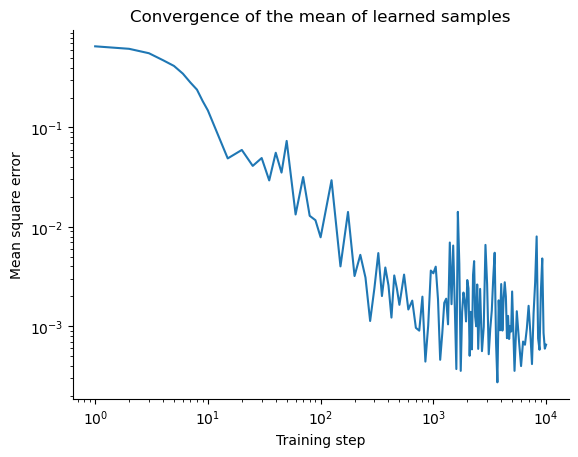

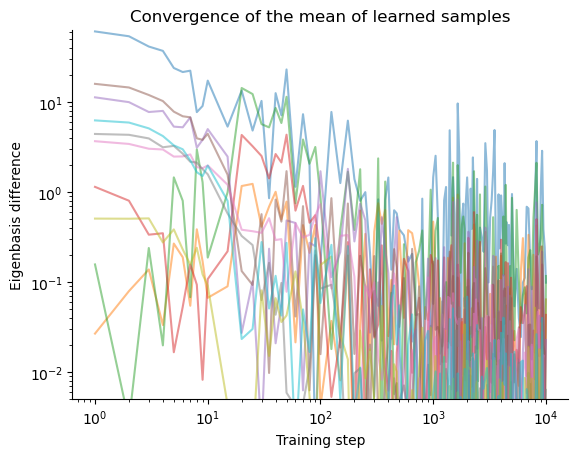

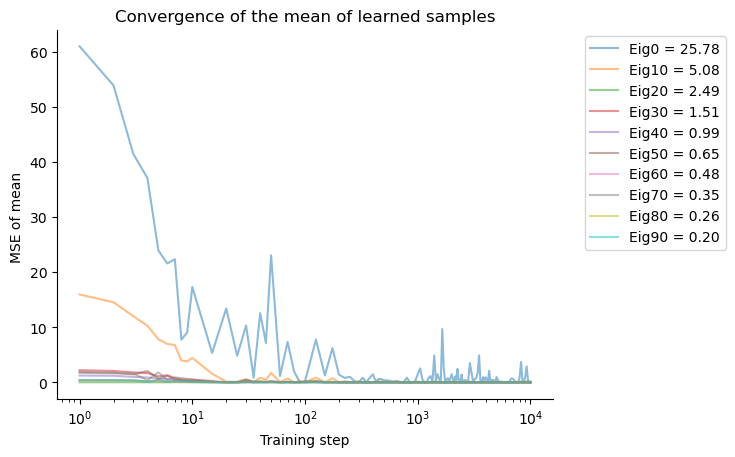

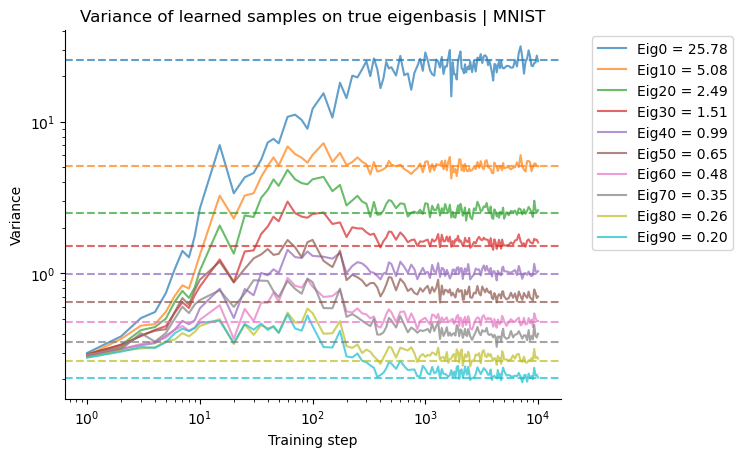

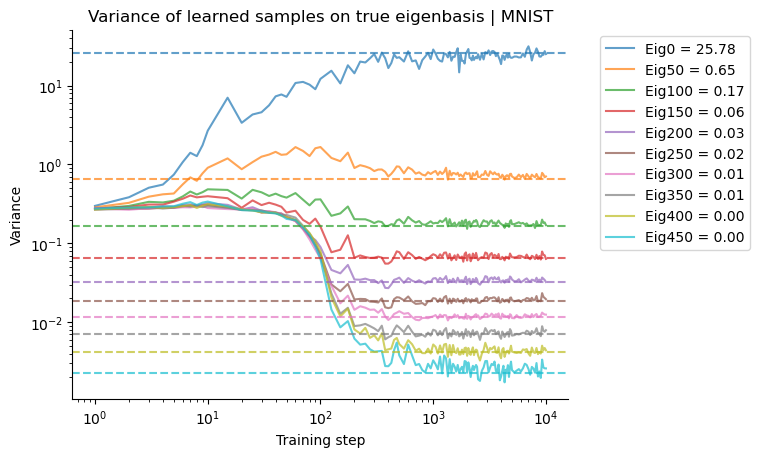

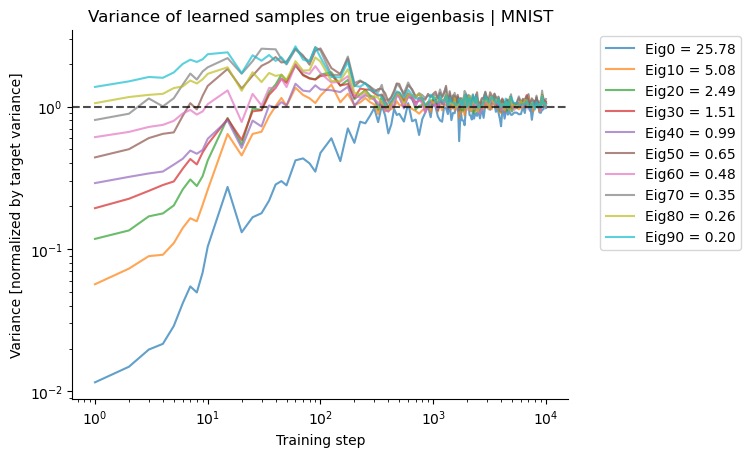

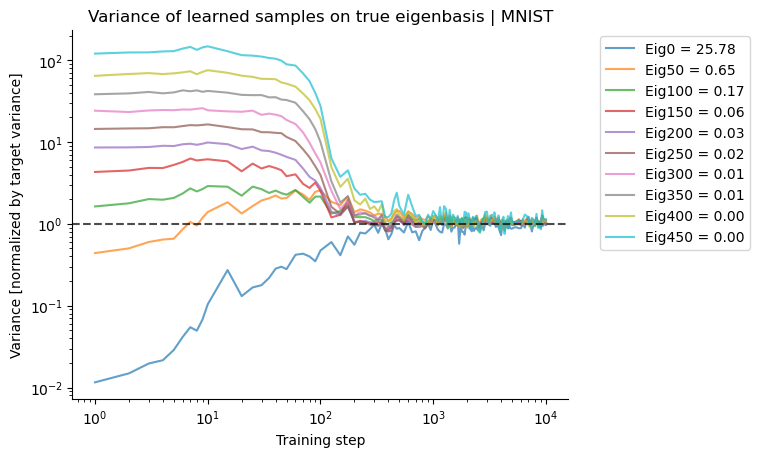

In [10]:

# plot the convergence of the mean 
mean_X_loss = (mean_x_sample_traj.to(device) - X_mean.to(device)).pow(2).mean(dim=1)
plt.figure()
plt.plot(step_slice, mean_X_loss.cpu().numpy(), label="MSE of mean")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Mean square error")
plt.title("Convergence of the mean of learned samples")
saveallforms(savedir, "sample_mean_convergence_MSE_traj_loglog")
plt.show()

# %%
# Project the difference of mean on the true eigenbasis
mean_X_diff_true_basis = (mean_x_sample_traj.to(device) - X_mean.to(device)) @ rot.to(device)
MSE_X_diff_true_basis = mean_X_diff_true_basis.pow(2).cpu()
slice2plot = slice(None, 20, 2)
plt.figure()
plt.plot(step_slice, MSE_X_diff_true_basis.numpy()[:, slice2plot], label="Eigenbasis difference", alpha=0.5)
plt.ylim(5E-3, None)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Eigenbasis difference")
plt.title("Convergence of the mean of learned samples")
saveallforms(savedir, "sample_mean_convergence_eigenbasis_MSE_traj_top20_loglog")
plt.show()

# %%
# Project the difference of mean on the true eigenbasis
mean_X_diff_true_basis = (mean_x_sample_traj.to(device) - X_mean.to(device)) @ rot.to(device)
MSE_X_diff_true_basis = mean_X_diff_true_basis.pow(2).cpu()
slice2plot = slice(None, 100, 10)
plt.figure()
plt.plot(step_slice, MSE_X_diff_true_basis.numpy()[:, slice2plot], label="Eigenbasis difference", alpha=0.5)
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("MSE of mean ")
plt.title("Convergence of the mean of learned samples")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, "sample_mean_convergence_eigenbasis_MSE_traj_top100")
plt.show()

# %%
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 100, 10)
plt.figure()
plt.plot(step_slice, diag_cov_x_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_raw_top100")
plt.show()

# %%
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 500, 50)
plt.figure()
plt.plot(step_slice, diag_cov_x_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_raw_top500")
plt.show()

# %%
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 100, 10)
plt.figure()
plt.plot(step_slice, diag_cov_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_normalized_top100")
plt.show()

# %%
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 500, 50)
plt.figure()
plt.plot(step_slice, diag_cov_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_normalized_top500")
plt.show()

### Patch statisics 


In [ ]:
def extract_patches(images, patch_size, patch_stride):
    B, C, H, W = images.shape
    patches = images.unfold(2, patch_size, patch_stride).unfold(3, patch_size, patch_stride)
    patches = patches.contiguous().view(B, C, -1, patch_size, patch_size)
    patches = patches.permute(0, 2, 1, 3, 4).contiguous().view(-1, C, patch_size, patch_size)
    return patches

images = Xtsr.view(Xtsr.shape[0], 1, 32, 32)
patches = extract_patches(images, patch_size=3, patch_stride=3)
patch_shape = patches.shape[1:]
patch_dim = np.prod(patch_shape)

torch.Size([6000000, 1, 3, 3])

In [12]:
images = Xtsr.view(Xtsr.shape[0], 1, 32, 32)

### Smallest patch 3x3 stride 1

In [16]:
patch_mean, patch_cov, patch_eigval, patch_eigvec, \
    mean_x_patch_sample_traj, cov_x_patch_sample_traj, diag_cov_x_patch_sample_true_eigenbasis_traj = \
    process_patch_mean_cov_statistics(images, sample_store, savedir, patch_size=3, patch_stride=1, imgshape=(1, 32, 32))

patch_cov.shape: torch.Size([9]) computed on 60000 images


  0%|          | 0/124 [00:00<?, ?it/s]

Saved to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_4blocks_noattn/sample_patch_3x3_stride_1_cov_true_eigenbasis_diag_traj.pkl


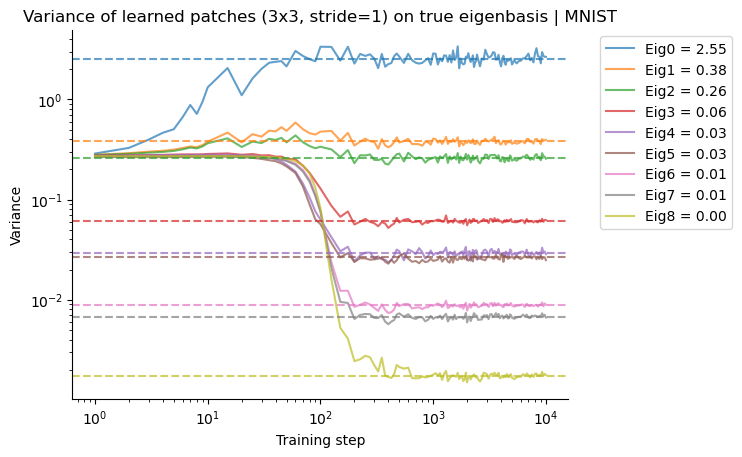

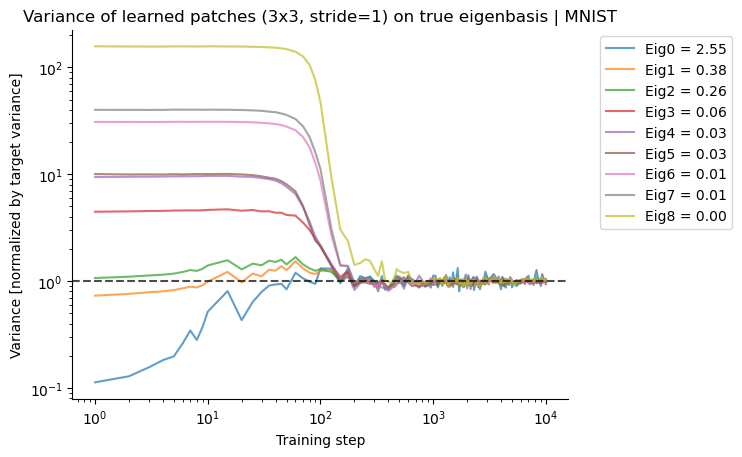

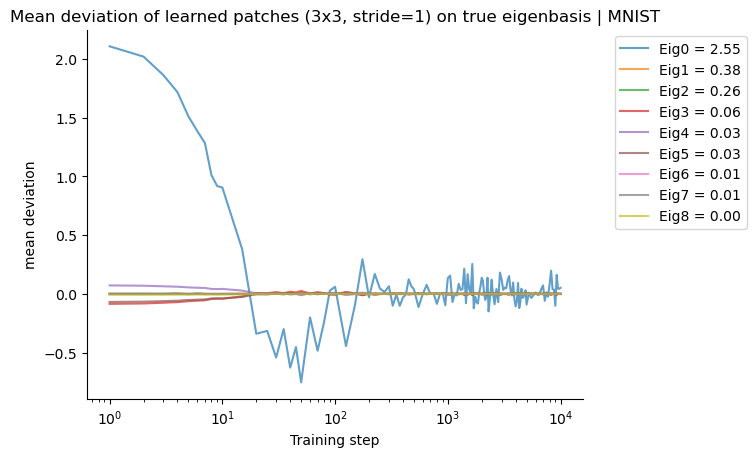

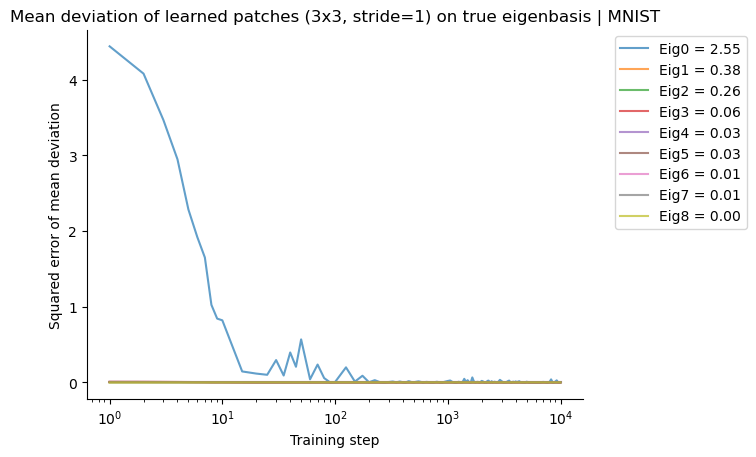

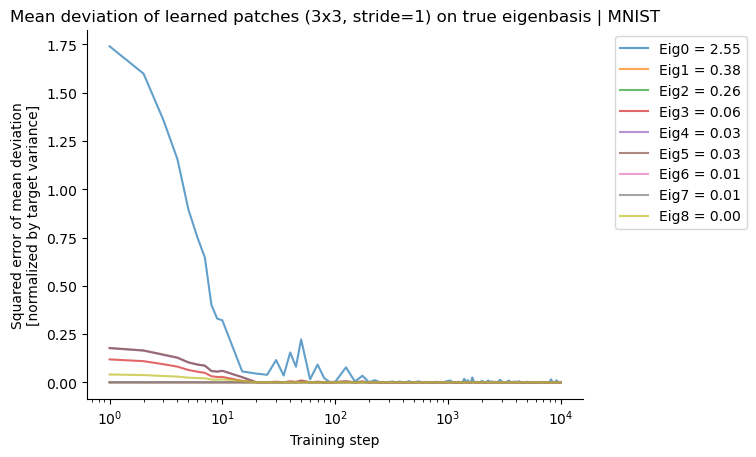

In [18]:
step_slice = sorted([*sample_store.keys()])
slice2plot = slice(None, 9, 1)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), 
                           slice2plot, patch_size=3, patch_stride=1, savedir=savedir, dataset_name="MNIST")
plot_mean_deviation_trajectories(step_slice, mean_x_patch_sample_traj, patch_mean.cpu(), patch_eigvec.cpu(), patch_eigval.cpu(), 
                           slice2plot, patch_size=3, patch_stride=1, savedir=savedir, dataset_name="MNIST")

### Patch 6x6 stride 1

In [29]:
patch_mean, patch_cov, patch_eigval, patch_eigvec, \
    mean_x_patch_sample_traj, cov_x_patch_sample_traj, diag_cov_x_patch_sample_true_eigenbasis_traj = \
    process_patch_mean_cov_statistics(images, sample_store, savedir, patch_size=6, patch_stride=1, imgshape=(1, 32, 32))

patch_cov.shape: torch.Size([36]) computed on 60000 images


  0%|          | 0/124 [00:00<?, ?it/s]

Saved to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_4blocks_noattn/sample_patch_6x6_stride_1_cov_true_eigenbasis_diag_traj.pkl


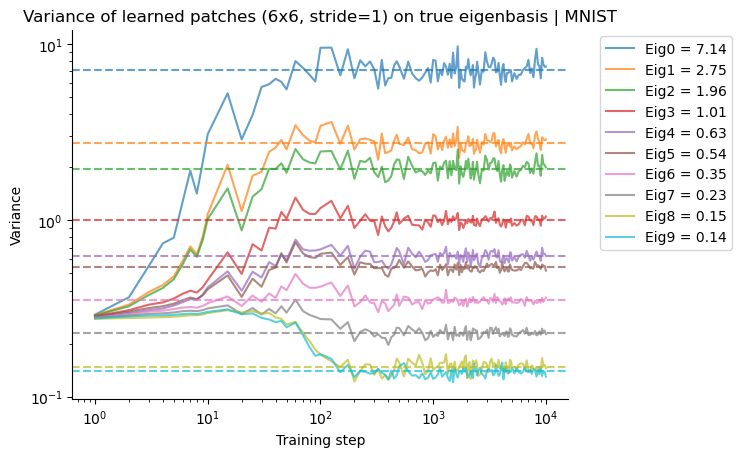

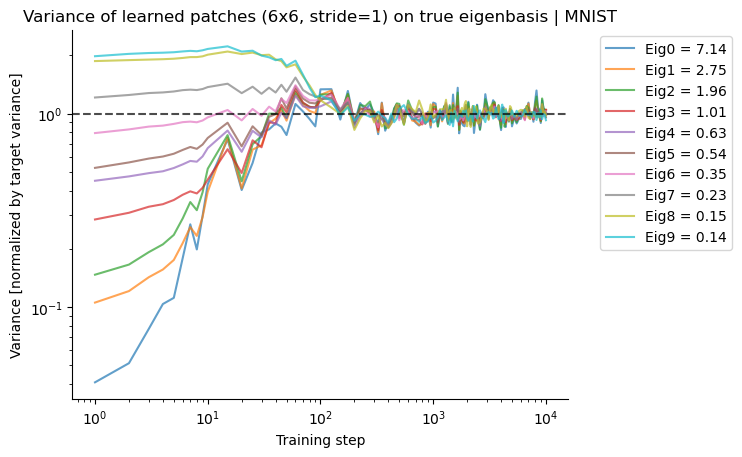

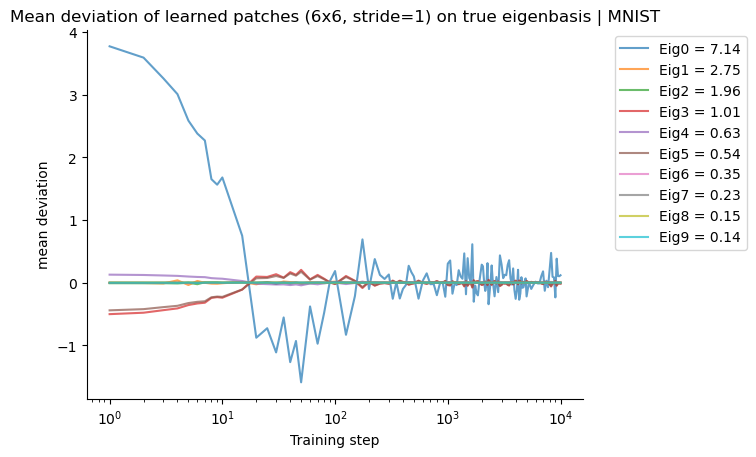

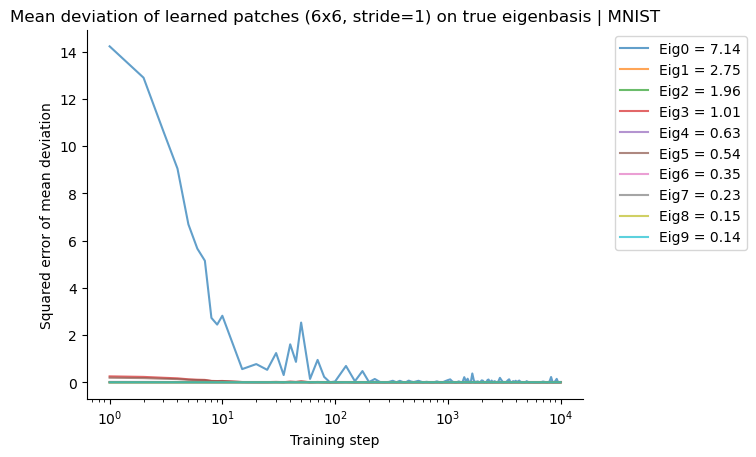

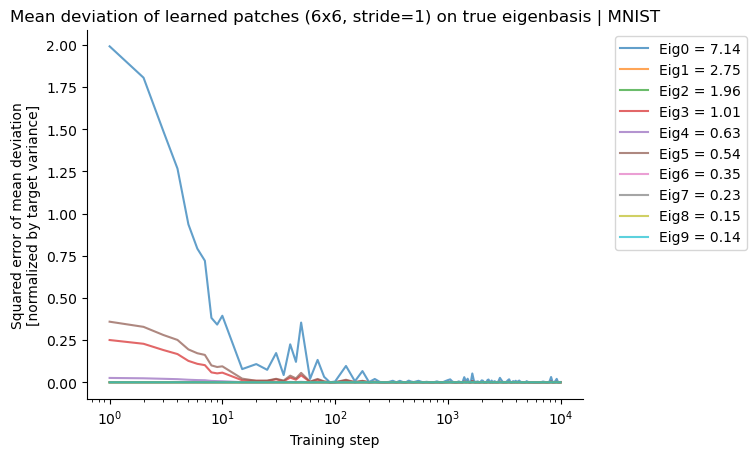

In [30]:
step_slice = sorted([*sample_store.keys()])
slice2plot = slice(None, 10, 1)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), 
                           slice2plot, patch_size=6, patch_stride=1, savedir=savedir, dataset_name="MNIST")
plot_mean_deviation_trajectories(step_slice, mean_x_patch_sample_traj, patch_mean.cpu(), patch_eigvec.cpu(), patch_eigval.cpu(), 
                           slice2plot, patch_size=6, patch_stride=1, savedir=savedir, dataset_name="MNIST")

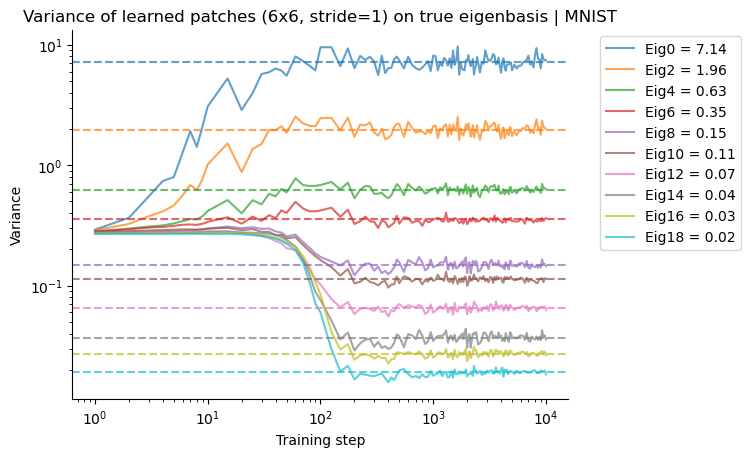

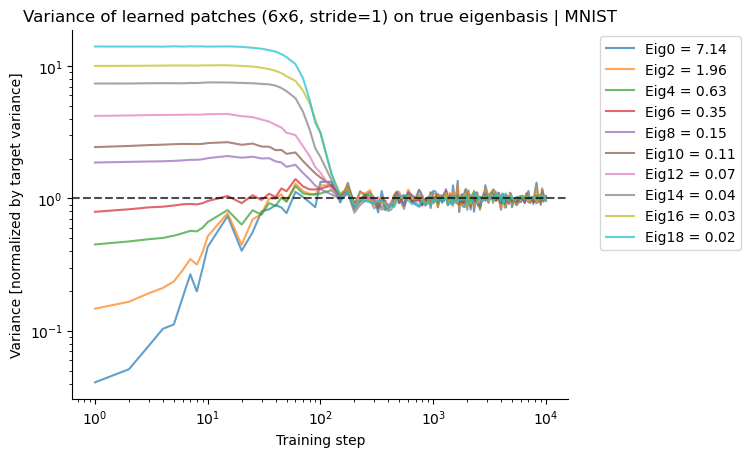

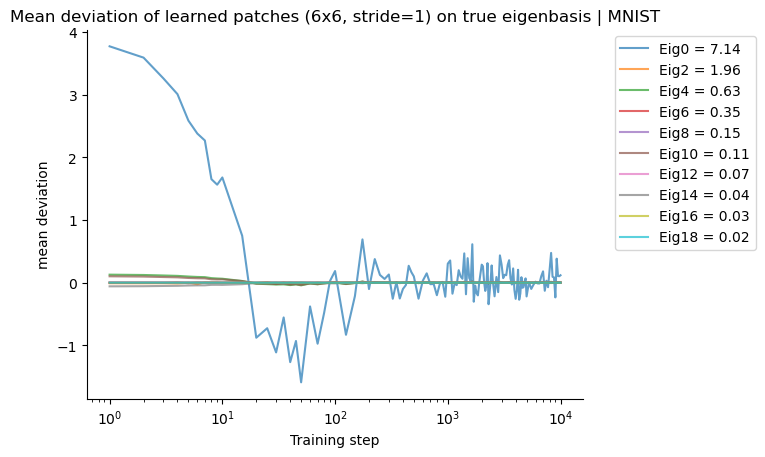

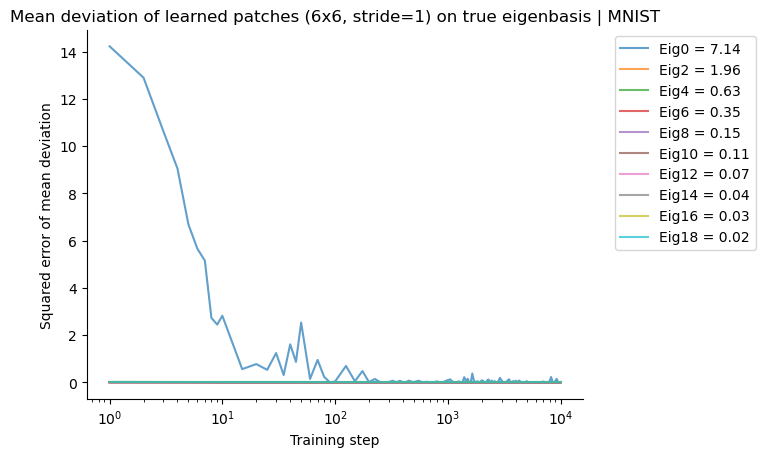

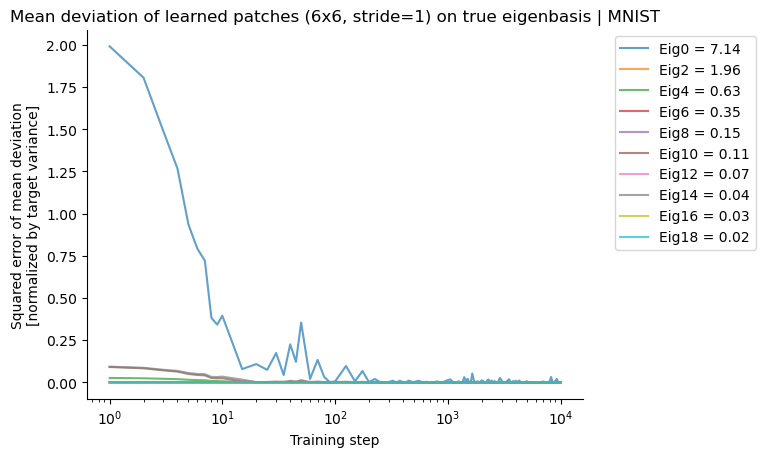

In [31]:
step_slice = sorted([*sample_store.keys()])
slice2plot = slice(None, 20, 2)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), 
                           slice2plot, patch_size=6, patch_stride=1, savedir=savedir, dataset_name="MNIST")
plot_mean_deviation_trajectories(step_slice, mean_x_patch_sample_traj, patch_mean.cpu(), patch_eigvec.cpu(), patch_eigval.cpu(), 
                           slice2plot, patch_size=6, patch_stride=1, savedir=savedir, dataset_name="MNIST")

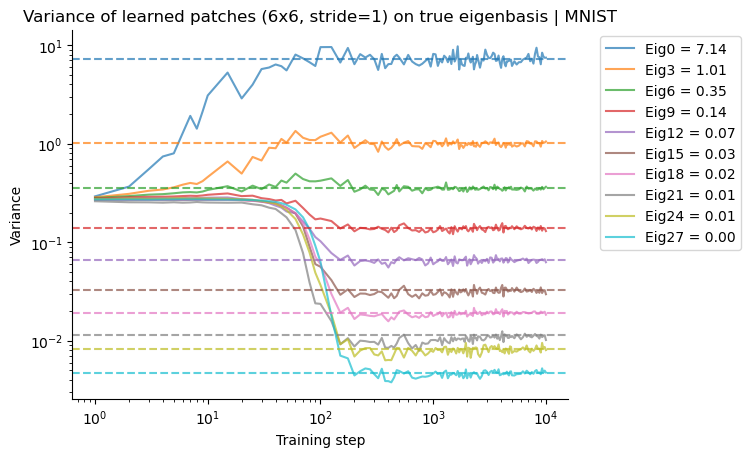

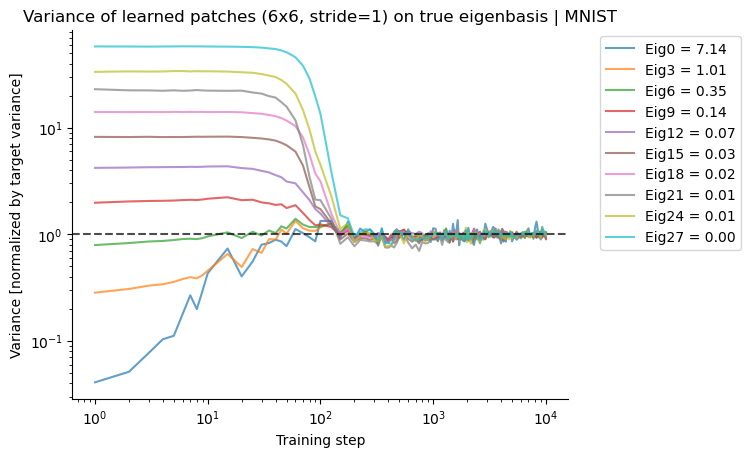

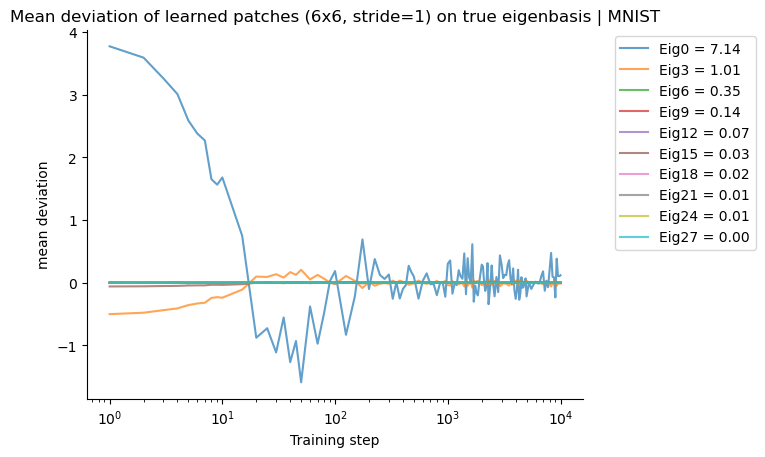

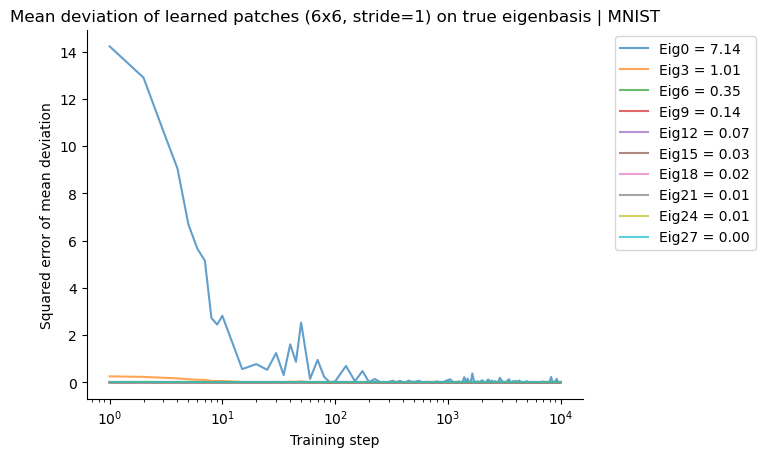

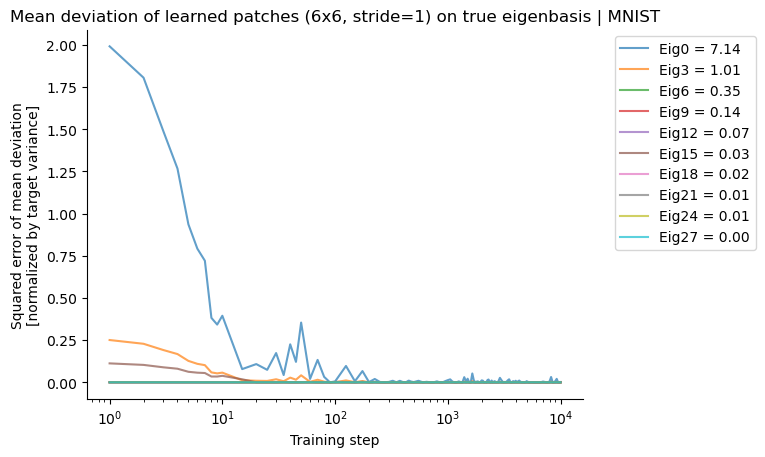

In [32]:
step_slice = sorted([*sample_store.keys()])
slice2plot = slice(None, 30, 3)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), 
                           slice2plot, patch_size=6, patch_stride=1, savedir=savedir, dataset_name="MNIST")
plot_mean_deviation_trajectories(step_slice, mean_x_patch_sample_traj, patch_mean.cpu(), patch_eigvec.cpu(), patch_eigval.cpu(), 
                           slice2plot, patch_size=6, patch_stride=1, savedir=savedir, dataset_name="MNIST")

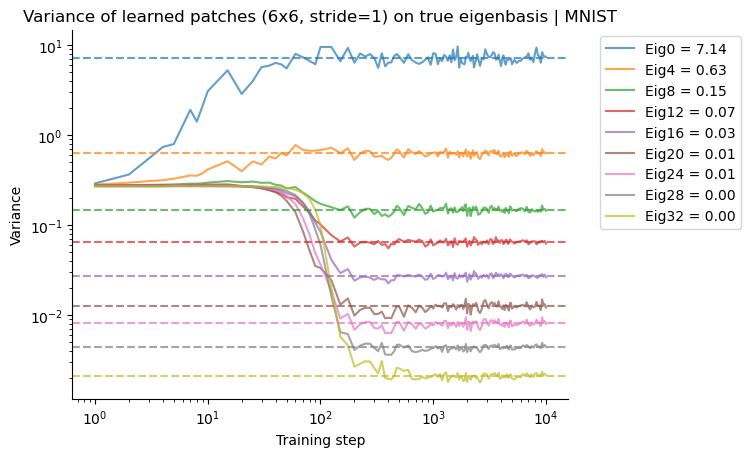

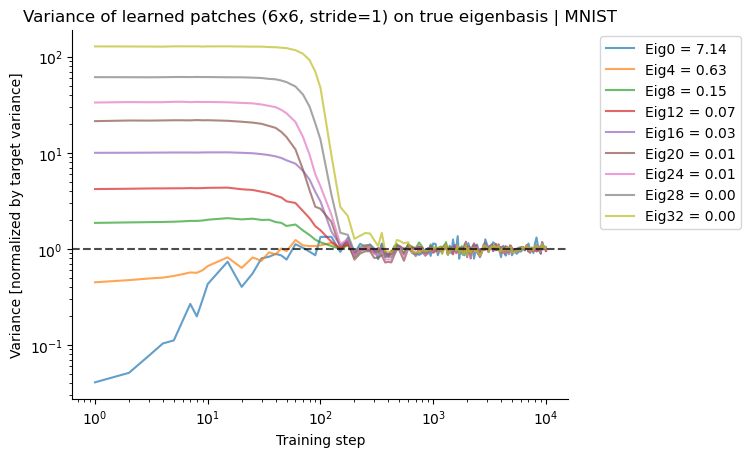

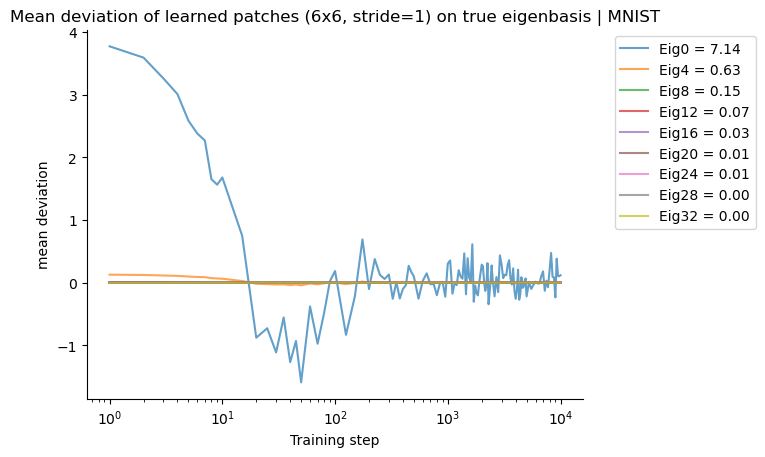

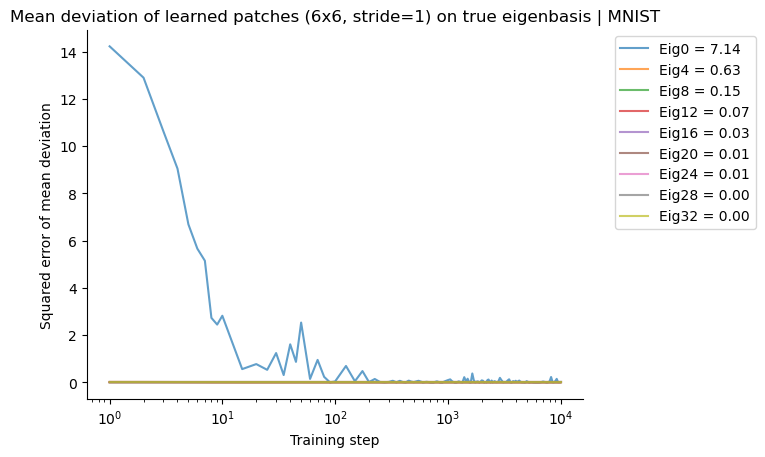

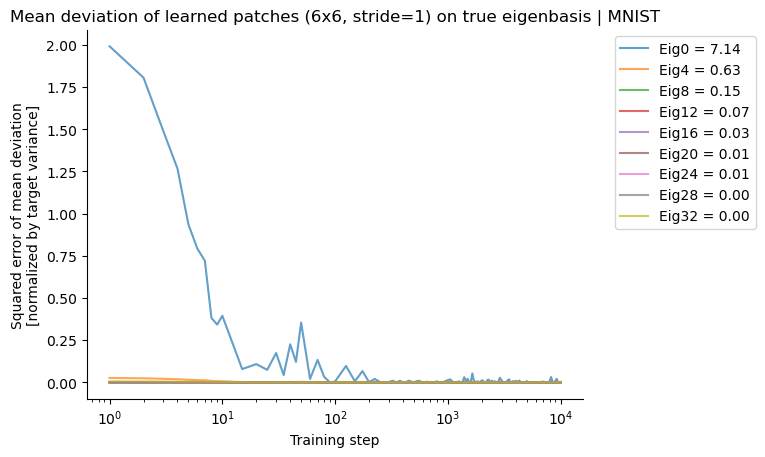

In [33]:
step_slice = sorted([*sample_store.keys()])
slice2plot = slice(None, None, 4)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), 
                           slice2plot, patch_size=6, patch_stride=1, savedir=savedir, dataset_name="MNIST")
plot_mean_deviation_trajectories(step_slice, mean_x_patch_sample_traj, patch_mean.cpu(), patch_eigvec.cpu(), patch_eigval.cpu(), 
                           slice2plot, patch_size=6, patch_stride=1, savedir=savedir, dataset_name="MNIST")

In [28]:
import numpy as np
from scipy.ndimage import gaussian_filter1d

def smooth_and_find_threshold_crossing(trajectory, threshold, first_crossing=False, smooth_sigma=2):
    if isinstance(trajectory, torch.Tensor):
        trajectory = trajectory.cpu().numpy()
    if isinstance(threshold, torch.Tensor):
        threshold = threshold.cpu().numpy()
    smoothed_trajectory = gaussian_filter1d(trajectory, sigma=smooth_sigma)
    # determine the direction of the crossing
    direction = 1 if smoothed_trajectory[0] > threshold else -1
    if direction == 1:
        crossing_indices = np.where(smoothed_trajectory < threshold)[0]
    else:
        crossing_indices = np.where(smoothed_trajectory > threshold)[0]
    if len(crossing_indices) > 0:
        return crossing_indices[0] if first_crossing else crossing_indices[-1], direction
    else:
        return None, direction

import numpy as np
import torch
from scipy.ndimage import gaussian_filter1d

def smooth_and_find_range_crossing(trajectory, LB, UB, smooth_sigma=2):
    """
    Smooths the trajectory and finds the first crossing into the range [LB, UB].
    
    Parameters:
        trajectory (np.ndarray or torch.Tensor): The input trajectory data.
        LB (float or np.ndarray or torch.Tensor): Lower bound of the range.
        UB (float or np.ndarray or torch.Tensor): Upper bound of the range.
        smooth_sigma (float): Standard deviation for Gaussian kernel used in smoothing.
        
    Returns:
        crossing_index (int or None): The index where the trajectory first enters the range.
        direction (str or None): Direction of crossing ('upward' or 'downward').
    """
    # Convert tensors to numpy arrays if necessary
    if isinstance(trajectory, torch.Tensor):
        trajectory = trajectory.cpu().numpy()
    if isinstance(LB, torch.Tensor):
        LB = LB.cpu().numpy()
    if isinstance(UB, torch.Tensor):
        UB = UB.cpu().numpy()
    
    # Smooth the trajectory
    smoothed_trajectory = gaussian_filter1d(trajectory, sigma=smooth_sigma)
    
    # Ensure LB <= UB
    if np.any(LB > UB):
        raise ValueError("Lower bound LB must be less than or equal to upper bound UB.")
    
    # Initialize direction and crossing_index
    crossing_index = None
    direction = None
    
    # Iterate through the trajectory to find the first crossing into [LB, UB]
    for i in range(1, len(smoothed_trajectory)):
        prev = smoothed_trajectory[i-1]
        current = smoothed_trajectory[i]
        
        # Check if previous point was outside the range
        was_below = prev < LB
        was_above = prev > UB
        was_inside = LB <= prev <= UB
        
        # Current point is inside the range
        is_inside = LB <= current <= UB
        
        if not is_inside and was_inside:
            # Exiting the range, not entering
            continue
        if is_inside and not was_inside:
            # Entering the range
            if was_below:
                direction = -1 # 'upward'
            elif was_above:
                direction = 1 # 'downward'
            else:
                # In case previous point was not strictly above or below
                direction = 'unknown'
            crossing_index = i
            break  # Stop after finding the first crossing
    
    return crossing_index, direction

def harmonic_mean(A, B):
    return 2 / (1 / A + 1 / B)

In [29]:
import pandas as pd
def compute_crossing_points(patch_eigval, diag_cov_x_patch_sample_true_eigenbasis_traj, step_slice, smooth_sigma=2, threshold_type="harmonic_mean", threshold_fraction=0.2):
    num_trajectories = diag_cov_x_patch_sample_true_eigenbasis_traj.shape[1]
    crossing_steps = []
    directions = []
    for i in range(num_trajectories):
        trajectory = diag_cov_x_patch_sample_true_eigenbasis_traj[:, i]
        if threshold_type == "range":
            threshold = np.array([patch_eigval[i] * (1 - threshold_fraction), patch_eigval[i] * (1 + threshold_fraction)])
            crossing_idx, direction = smooth_and_find_range_crossing(trajectory, threshold[0], threshold[1], smooth_sigma=smooth_sigma)
        else:
            if threshold_type == "harmonic_mean":
                threshold = harmonic_mean(patch_eigval[i], trajectory[0])
            elif threshold_type == "mean":
                threshold = (patch_eigval[i] + trajectory[0]) / 2
            elif threshold_type == "geometric_mean":
                threshold = np.sqrt(patch_eigval[i] * trajectory[0])
            crossing_idx, direction = smooth_and_find_threshold_crossing(trajectory, threshold, first_crossing=True, smooth_sigma=smooth_sigma)
        if crossing_idx is not None:
            crossing_steps.append(step_slice[crossing_idx])
            directions.append(direction)
        else:
            print(f"No crossing found for mode {i}")
            crossing_steps.append(np.nan)
            directions.append(0)
    df = pd.DataFrame({"Variance": patch_eigval.cpu().numpy(), "emergence_step": crossing_steps, "direction": directions})
    # translate direction 1 -> decrease, -1 -> increase
    df["Direction"] = df["direction"].map({1: "decrease", -1: "increase"})
    return df


In [38]:
patch_size, patch_stride = 6, 1

In [39]:
step_slice = sorted([*sample_store.keys()])
num_trajectories = diag_cov_x_patch_sample_true_eigenbasis_traj.shape[1]
crossing_steps = []
directions = []
for i in range(num_trajectories):
    trajectory = diag_cov_x_patch_sample_true_eigenbasis_traj[:, i]
    threshold = harmonic_mean(patch_eigval[i], trajectory[0])
    crossing_idx, direction = smooth_and_find_threshold_crossing(trajectory, threshold, first_crossing=True)
    if crossing_idx is not None:
        crossing_steps.append(step_slice[crossing_idx])
        directions.append(direction)
    else:
        print(f"No crossing found for mode {i}")
        crossing_steps.append(np.nan)
        directions.append(0)

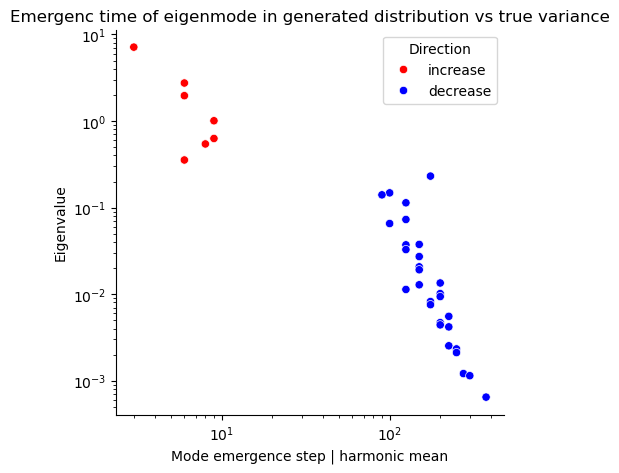

In [40]:
# make a dataframe
import pandas as pd
import seaborn as sns

df = pd.DataFrame({"Variance": patch_eigval.cpu().numpy(), "emergence_step": crossing_steps, "direction": directions})
# translate direction 1 -> decrease, -1 -> increase
df["Direction"] = df["direction"].map({1: "decrease", -1: "increase"})
# df.to_csv(f"{savedir}/crossing_points.csv", index=False)
figh = plt.figure(figsize=[5, 5])
# Decide which direction maps to which color
palette = {"decrease": "blue", "increase": "red"}
sns.scatterplot(data=df, x="emergence_step", y="Variance", hue="Direction", 
                palette=palette,)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mode emergence step | harmonic mean")
plt.ylabel("Eigenvalue")
plt.title("Emergenc time of eigenmode in generated distribution vs true variance")
saveallforms(savedir, f"synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance")
plt.show()
df.to_csv(f"{savedir}/synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)

#### Patch 9x9 stride 3

In [42]:
patch_size, patch_stride = 9, 3
patch_mean, patch_cov, patch_eigval, patch_eigvec, \
    mean_x_patch_sample_traj, cov_x_patch_sample_traj, diag_cov_x_patch_sample_true_eigenbasis_traj = \
    process_patch_mean_cov_statistics(images, sample_store, savedir, patch_size=patch_size, patch_stride=patch_stride, imgshape=(1, 32, 32))

patch_cov.shape: torch.Size([81]) computed on 60000 images


  0%|          | 0/124 [00:00<?, ?it/s]

Saved to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_4blocks_noattn/sample_patch_9x9_stride_3_cov_true_eigenbasis_diag_traj.pkl


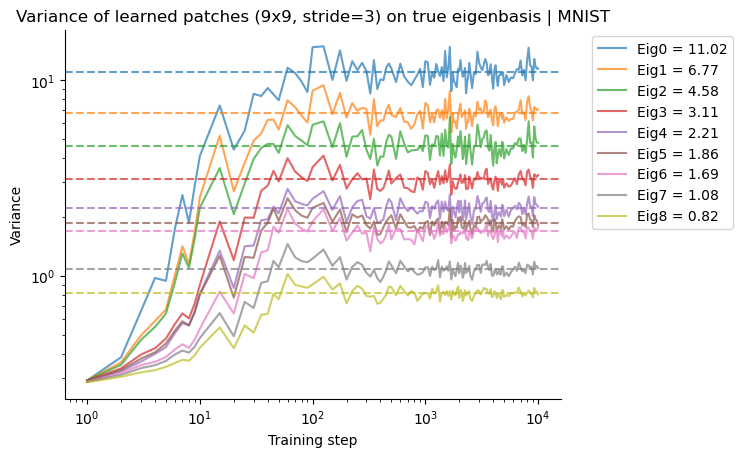

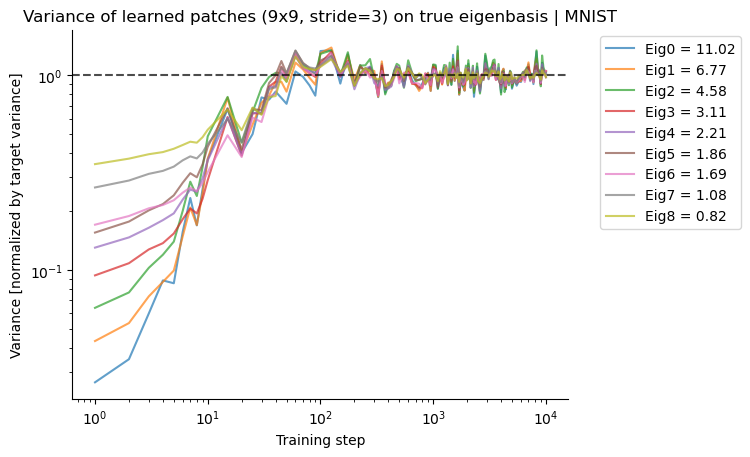

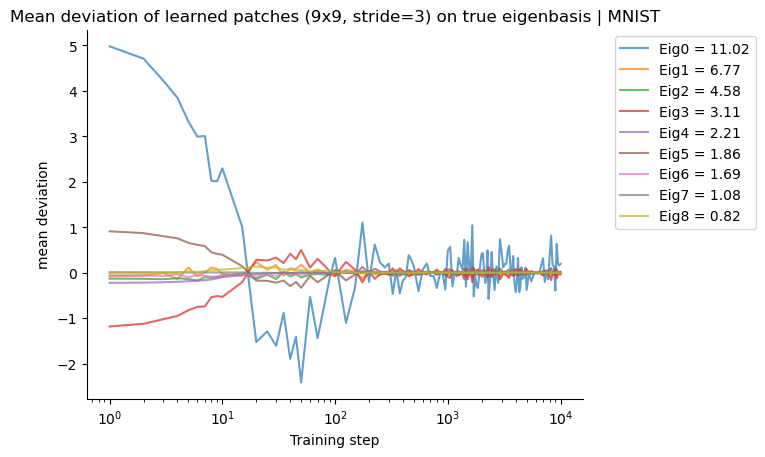

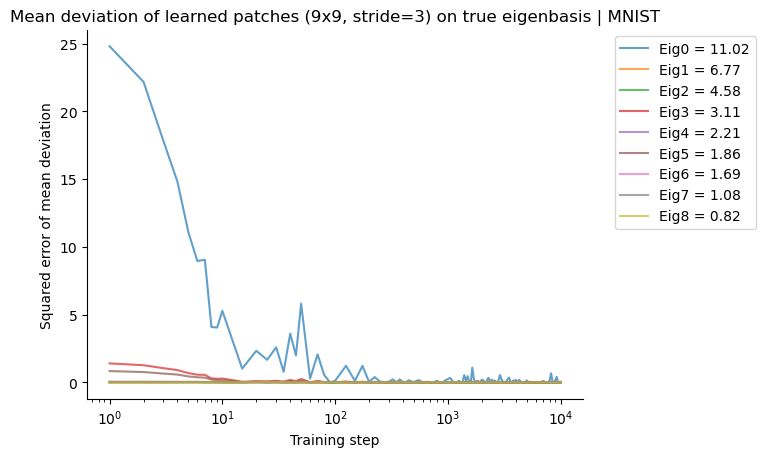

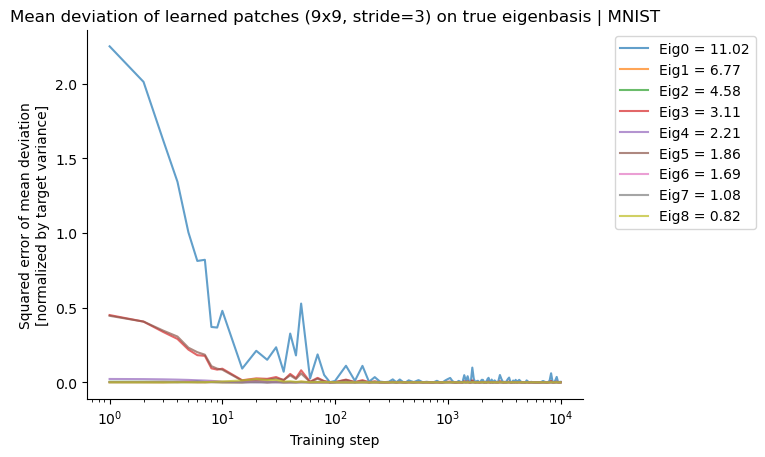

In [43]:
step_slice = sorted([*sample_store.keys()])
slice2plot = slice(None, 9, 1)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), 
                           slice2plot, patch_size=patch_size, patch_stride=patch_stride, savedir=savedir, dataset_name="MNIST")
plot_mean_deviation_trajectories(step_slice, mean_x_patch_sample_traj, patch_mean.cpu(), patch_eigvec.cpu(), patch_eigval.cpu(), 
                           slice2plot, patch_size=patch_size, patch_stride=patch_stride, savedir=savedir, dataset_name="MNIST")

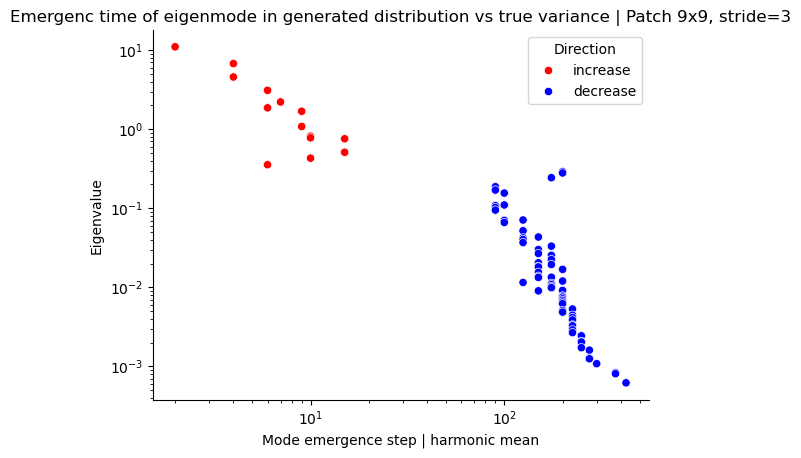

In [45]:
df = compute_crossing_points(patch_eigval, diag_cov_x_patch_sample_true_eigenbasis_traj, step_slice)
df.to_csv(f"{savedir}/synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)
sns.scatterplot(data=df, x="emergence_step", y="Variance", hue="Direction", palette=palette)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mode emergence step | harmonic mean")
plt.ylabel("Eigenvalue")
plt.title(f"Emergenc time of eigenmode in generated distribution vs true variance | Patch {patch_size}x{patch_size}, stride={patch_stride}")
saveallforms(savedir, f"synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance")
plt.show()

#### Large patch 32

In [46]:
patch_size, patch_stride = 32, 32
patch_mean, patch_cov, patch_eigval, patch_eigvec, \
    mean_x_patch_sample_traj, cov_x_patch_sample_traj, diag_cov_x_patch_sample_true_eigenbasis_traj = \
    process_patch_mean_cov_statistics(images, sample_store, savedir, patch_size=patch_size, patch_stride=patch_stride, imgshape=(1, 32, 32))

patch_cov.shape: torch.Size([1024]) computed on 60000 images


  0%|          | 0/124 [00:00<?, ?it/s]

Saved to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_4blocks_noattn/sample_patch_32x32_stride_32_cov_true_eigenbasis_diag_traj.pkl


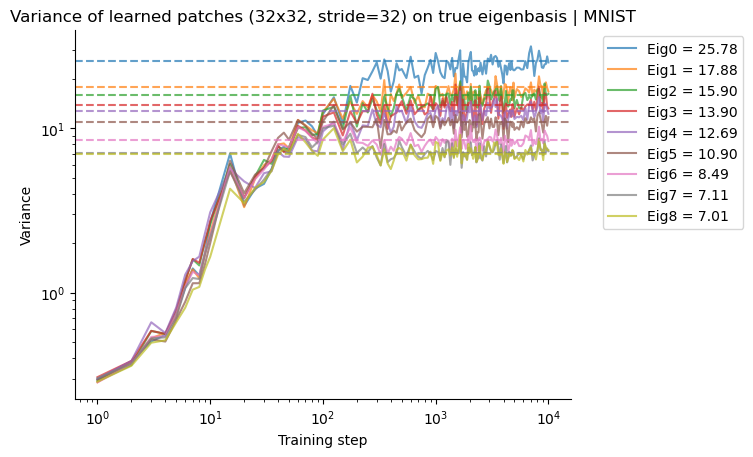

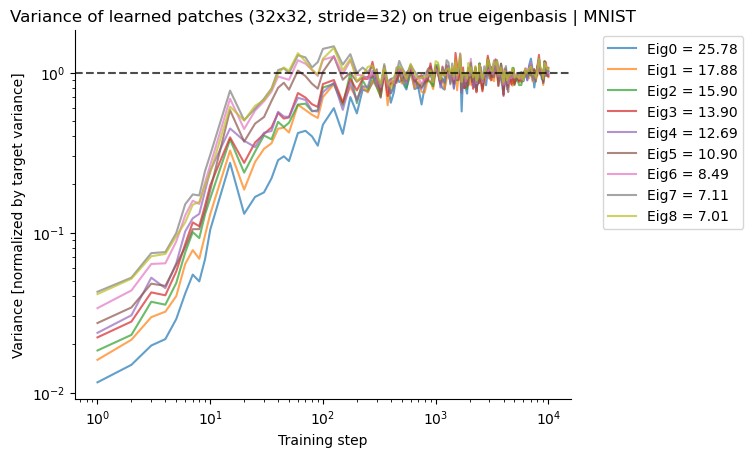

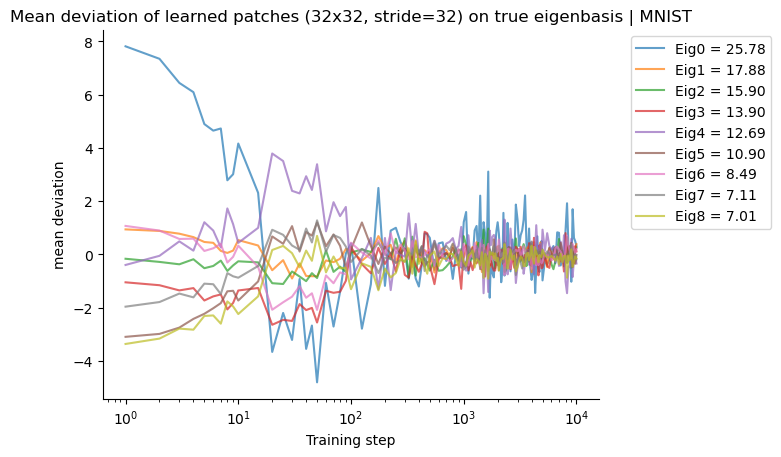

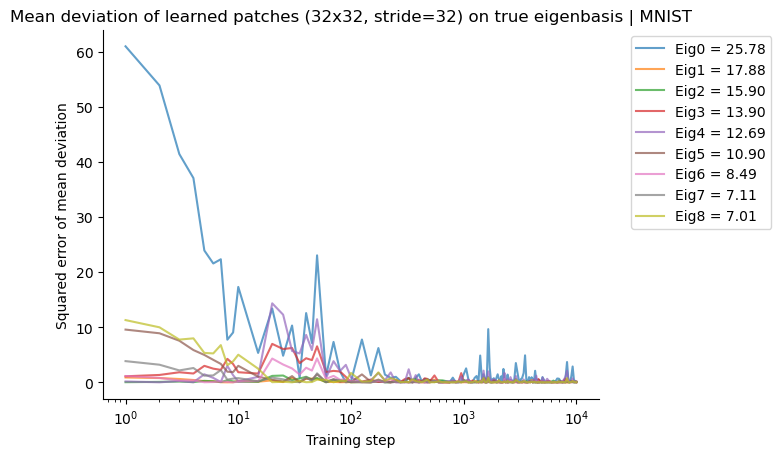

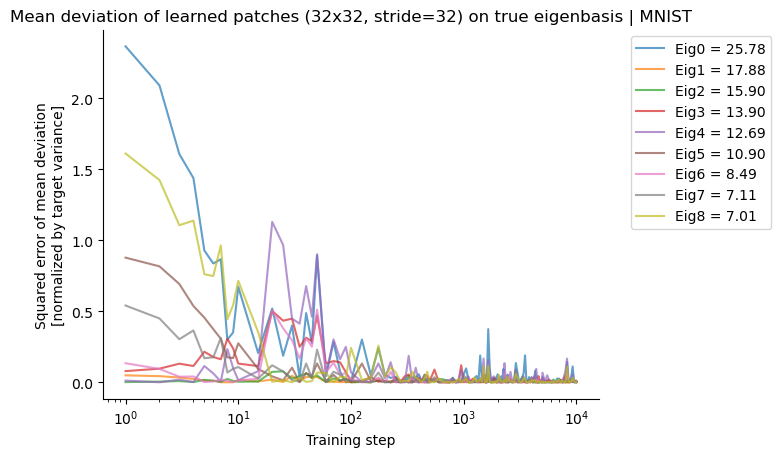

In [47]:
step_slice = sorted([*sample_store.keys()])
slice2plot = slice(None, 9, 1)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), 
                           slice2plot, patch_size=patch_size, patch_stride=patch_stride, savedir=savedir, dataset_name="MNIST")
plot_mean_deviation_trajectories(step_slice, mean_x_patch_sample_traj, patch_mean.cpu(), patch_eigvec.cpu(), patch_eigval.cpu(), 
                           slice2plot, patch_size=patch_size, patch_stride=patch_stride, savedir=savedir, dataset_name="MNIST")

No crossing found for mode 4
No crossing found for mode 65
No crossing found for mode 66
No crossing found for mode 67
No crossing found for mode 68
No crossing found for mode 69
No crossing found for mode 70
No crossing found for mode 71
No crossing found for mode 72
No crossing found for mode 73
No crossing found for mode 74
No crossing found for mode 75
No crossing found for mode 76
No crossing found for mode 77
No crossing found for mode 78
No crossing found for mode 79
No crossing found for mode 82
No crossing found for mode 610
No crossing found for mode 619
No crossing found for mode 626
No crossing found for mode 627
No crossing found for mode 634
No crossing found for mode 635
No crossing found for mode 644
No crossing found for mode 648
No crossing found for mode 652
No crossing found for mode 657
No crossing found for mode 659
No crossing found for mode 660
No crossing found for mode 661
No crossing found for mode 662
No crossing found for mode 664
No crossing found for mode

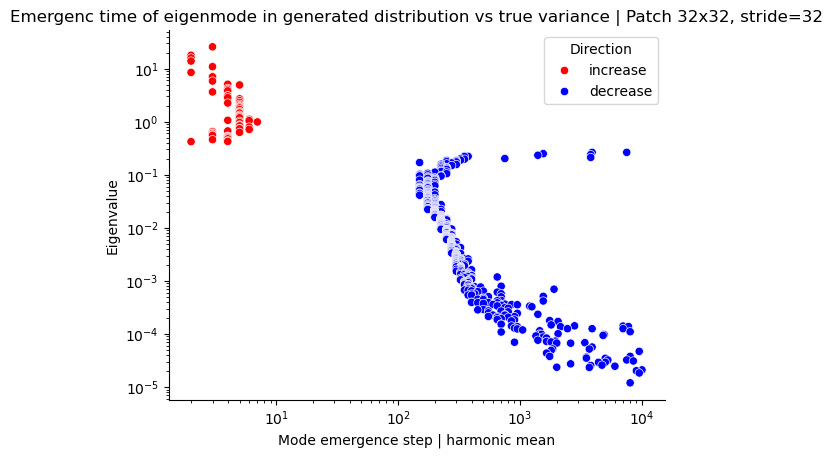

In [51]:
df = compute_crossing_points(patch_eigval, diag_cov_x_patch_sample_true_eigenbasis_traj, step_slice, smooth_sigma=3)
df.to_csv(f"{savedir}/synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)
sns.scatterplot(data=df, x="emergence_step", y="Variance", hue="Direction", palette=palette)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mode emergence step | harmonic mean")
plt.ylabel("Eigenvalue")
plt.title(f"Emergenc time of eigenmode in generated distribution vs true variance | Patch {patch_size}x{patch_size}, stride={patch_stride}")
saveallforms(savedir, f"synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance")
plt.show()

### 2nd run

In [7]:
saveroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"
savedir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_4blocks_noattn_smalllr_longtrain"

In [8]:
with open(f"{savedir}/sample_cov_true_eigenbasis_diag_traj.pkl", "rb") as f:
    data = pkl.load(f)
diag_cov_x_sample_true_eigenbasis_traj = data["diag_cov_x_sample_true_eigenbasis_traj"]
mean_x_sample_traj = data["mean_x_sample_traj"]
cov_x_sample_traj = data["cov_x_sample_traj"]
true_cov_eigs = data["true_cov_eigs"]
step_slice = data["step_slice"]

In [9]:
with open(f"{savedir}/train_data_cov_info.pkl", "rb") as f:
    data = pkl.load(f)
Xtsr = data["train_pnts"]
X_mean = data["X_mean"]
rot = data["rot"]
diag_var = data["diag_var"]
cov_empirical = data["cov_empirical"]
ndim = Xtsr.shape[1]

In [10]:
with open(f"{savedir}/sample_store.pkl", "rb") as f:
    sample_store = pkl.load(f)

#### Patch 3x3 

In [11]:
images = Xtsr.view(Xtsr.shape[0], 1, 32, 32)

In [12]:
patch_mean, patch_cov, patch_eigval, patch_eigvec, \
    mean_x_patch_sample_traj, cov_x_patch_sample_traj, diag_cov_x_patch_sample_true_eigenbasis_traj = \
    process_patch_mean_cov_statistics(images, sample_store, savedir, patch_size=3, patch_stride=1, imgshape=(1, 32, 32))

patch_cov.shape: torch.Size([9]) computed on 60000 images


  0%|          | 0/592 [00:00<?, ?it/s]

Saved to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_4blocks_noattn_smalllr_longtrain/sample_patch_3x3_stride_1_cov_true_eigenbasis_diag_traj.pkl


In [14]:
figdir = join(savedir, "figures")
os.makedirs(figdir, exist_ok=True)

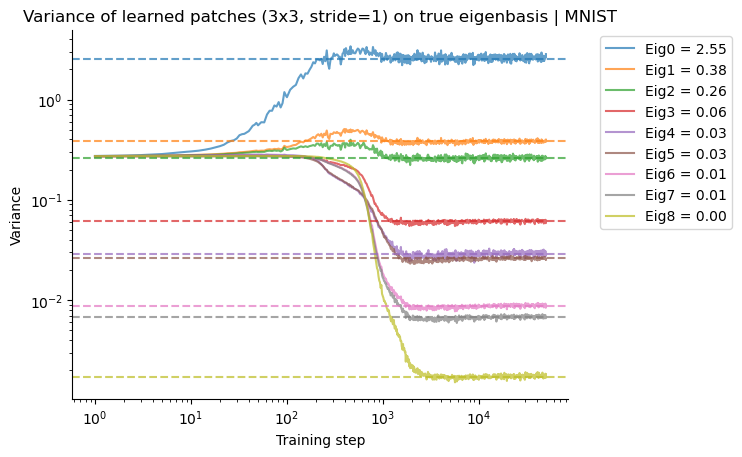

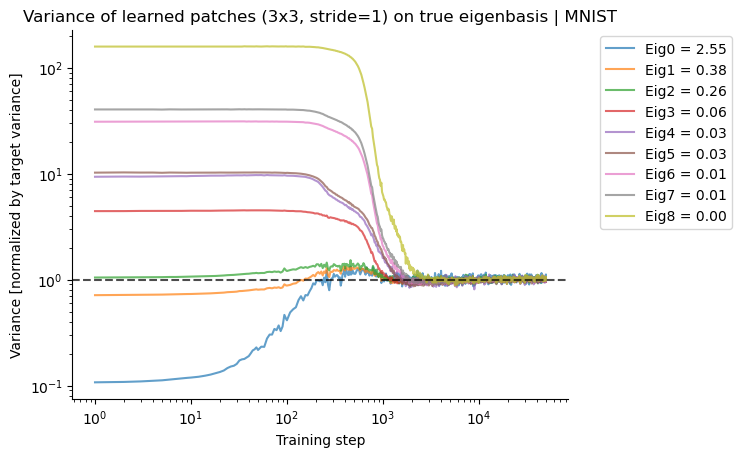

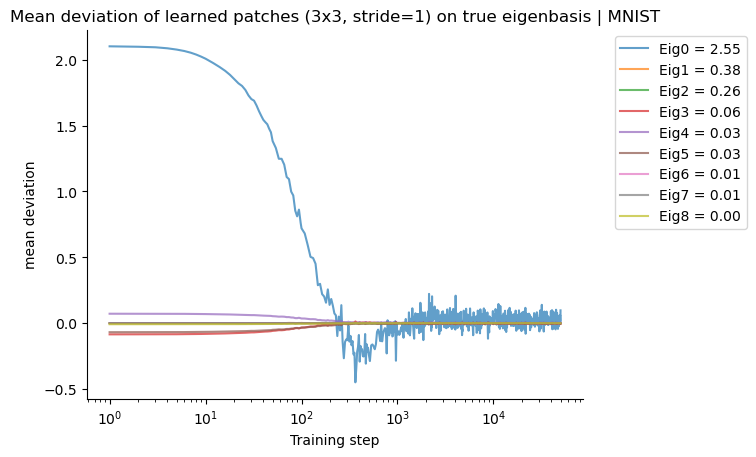

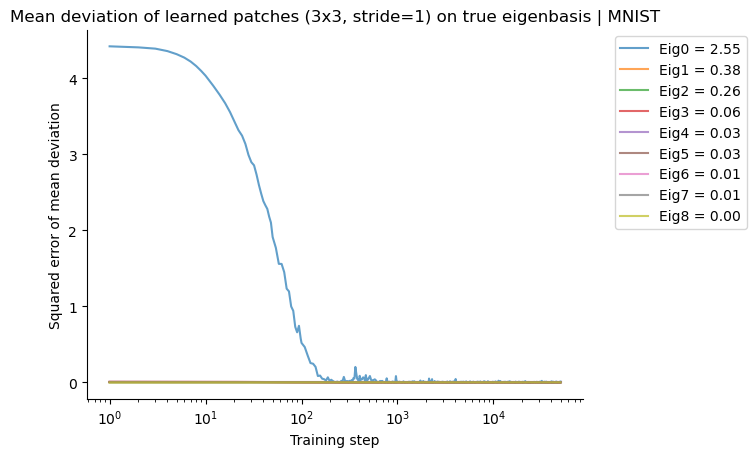

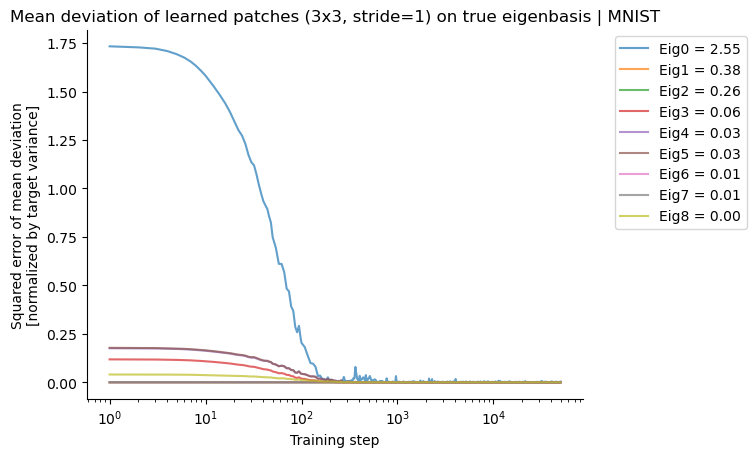

In [15]:
step_slice = sorted([*sample_store.keys()])
slice2plot = slice(None, 9, 1)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), 
                           slice2plot, patch_size=3, patch_stride=1, savedir=figdir, dataset_name="MNIST")
plot_mean_deviation_trajectories(step_slice, mean_x_patch_sample_traj, patch_mean.cpu(), patch_eigvec.cpu(), patch_eigval.cpu(), 
                           slice2plot, patch_size=3, patch_stride=1, savedir=savedir, dataset_name="MNIST")

#### Patch 6x6

In [16]:
patch_size, patch_stride = 6, 1
patch_mean, patch_cov, patch_eigval, patch_eigvec, \
    mean_x_patch_sample_traj, cov_x_patch_sample_traj, diag_cov_x_patch_sample_true_eigenbasis_traj = \
    process_patch_mean_cov_statistics(images, sample_store, savedir, patch_size=patch_size, patch_stride=patch_stride, imgshape=(1, 32, 32))

patch_cov.shape: torch.Size([36]) computed on 60000 images


  0%|          | 0/592 [00:00<?, ?it/s]

Saved to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_4blocks_noattn_smalllr_longtrain/sample_patch_6x6_stride_1_cov_true_eigenbasis_diag_traj.pkl


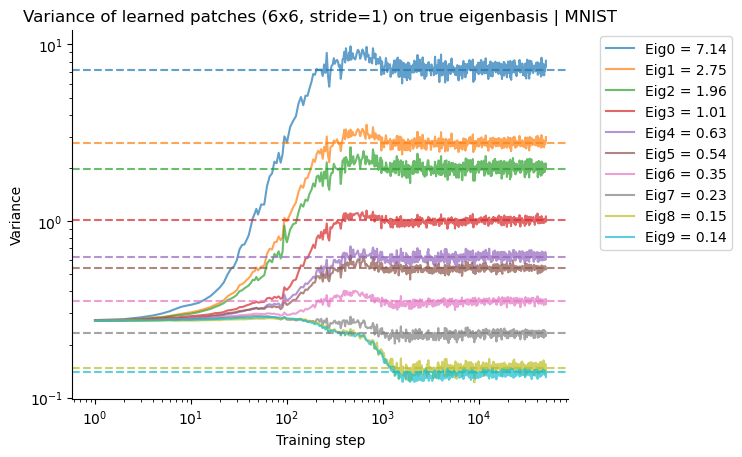

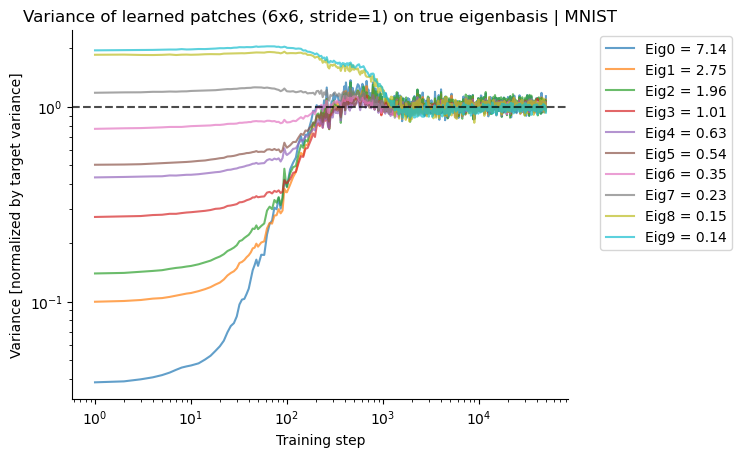

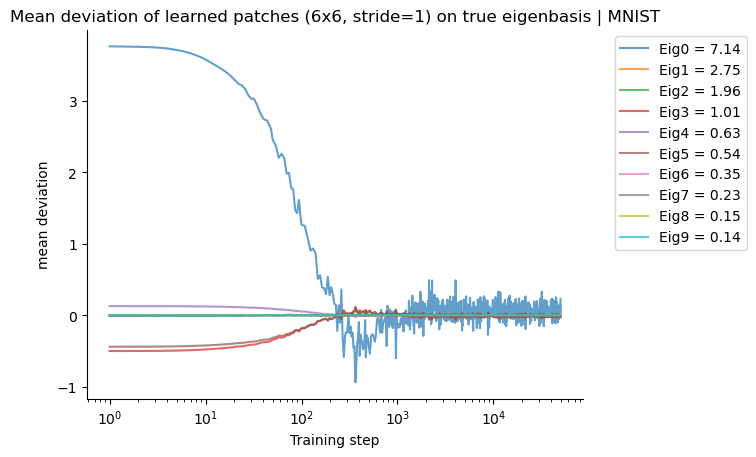

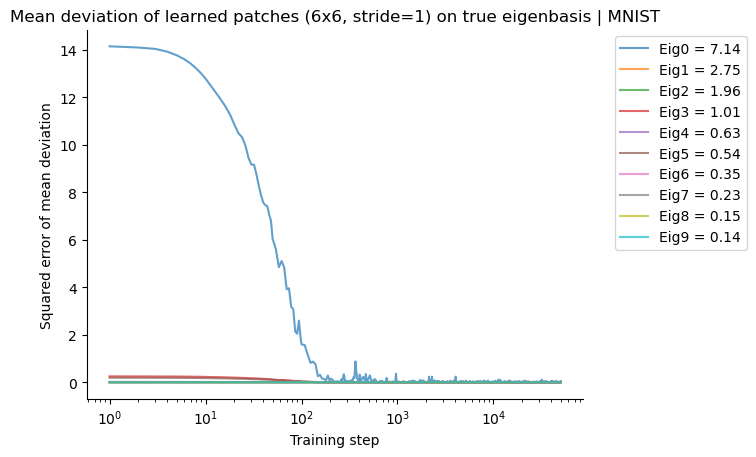

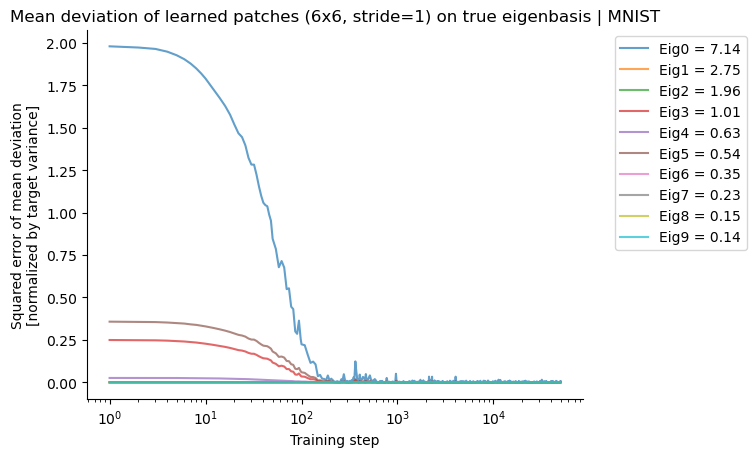

In [17]:
step_slice = sorted([*sample_store.keys()])
slice2plot = slice(None, 10, 1)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), 
                           slice2plot, patch_size=patch_size, patch_stride=patch_stride, savedir=figdir, dataset_name="MNIST")
plot_mean_deviation_trajectories(step_slice, mean_x_patch_sample_traj, patch_mean.cpu(), patch_eigvec.cpu(), patch_eigval.cpu(), 
                           slice2plot, patch_size=patch_size, patch_stride=patch_stride, savedir=figdir, dataset_name="MNIST")

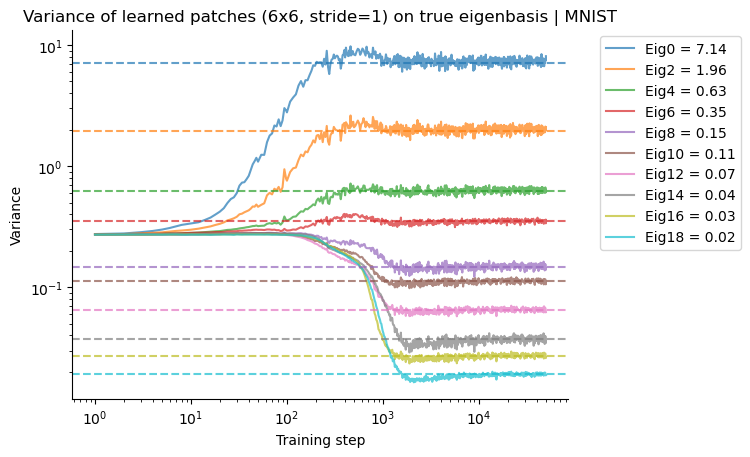

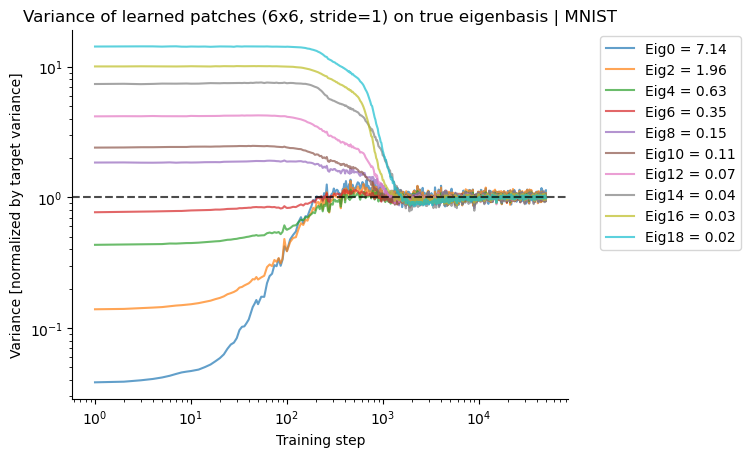

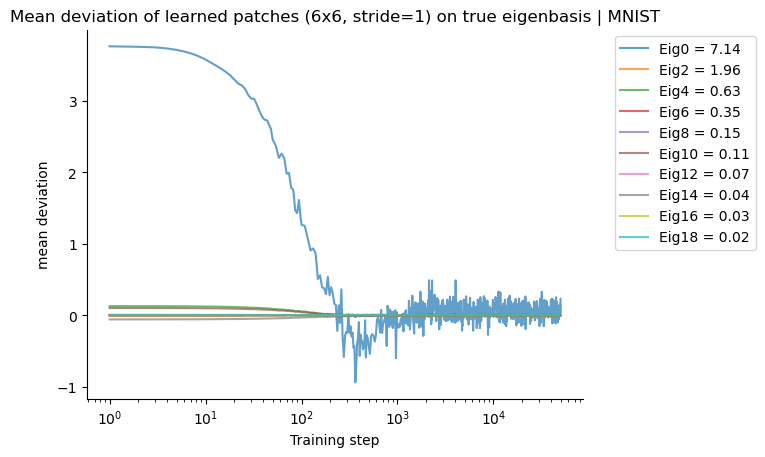

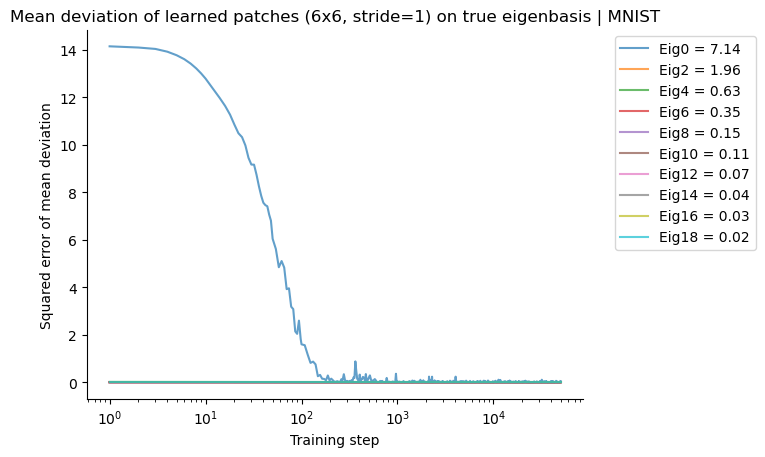

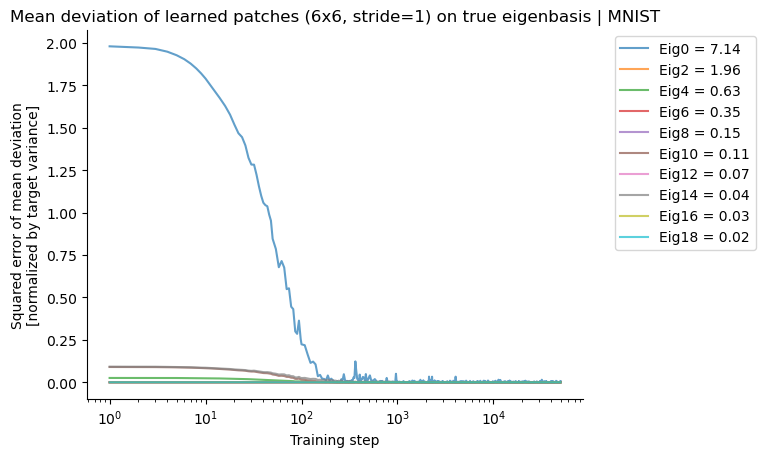

In [18]:
step_slice = sorted([*sample_store.keys()])
slice2plot = slice(None, 20, 2)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), 
                           slice2plot, patch_size=patch_size, patch_stride=patch_stride, savedir=figdir, dataset_name="MNIST")
plot_mean_deviation_trajectories(step_slice, mean_x_patch_sample_traj, patch_mean.cpu(), patch_eigvec.cpu(), patch_eigval.cpu(), 
                           slice2plot, patch_size=patch_size, patch_stride=patch_stride, savedir=figdir, dataset_name="MNIST")

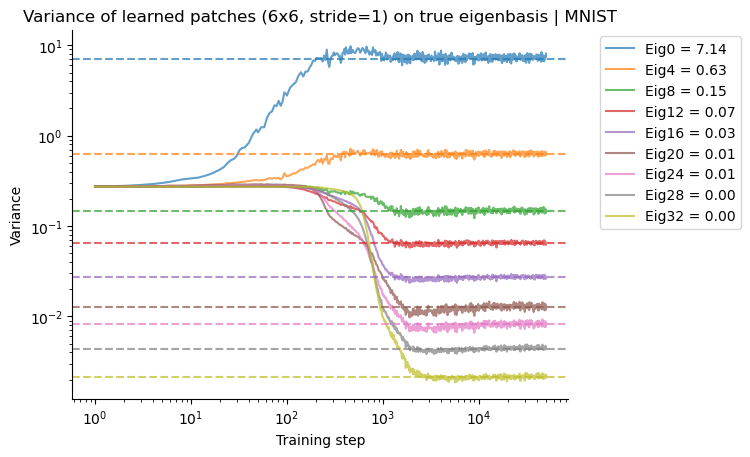

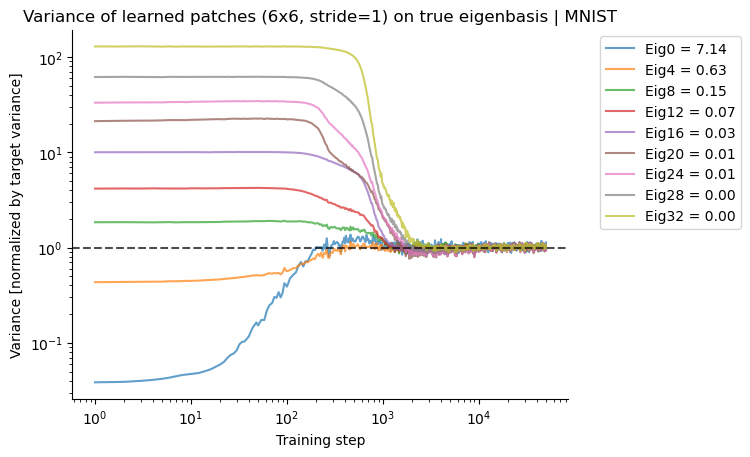

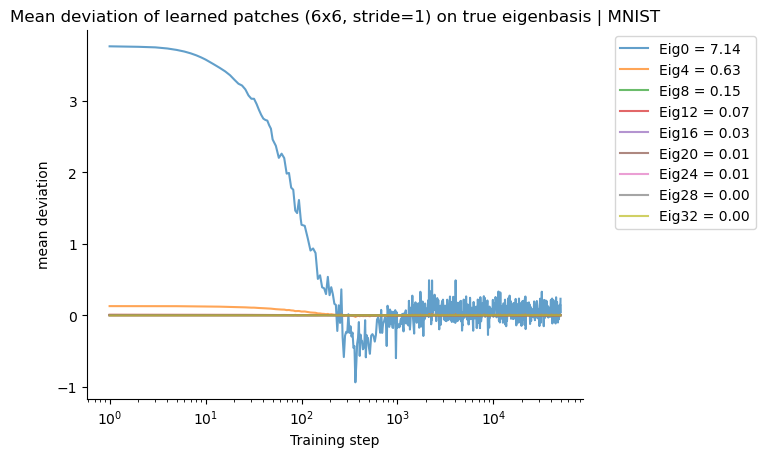

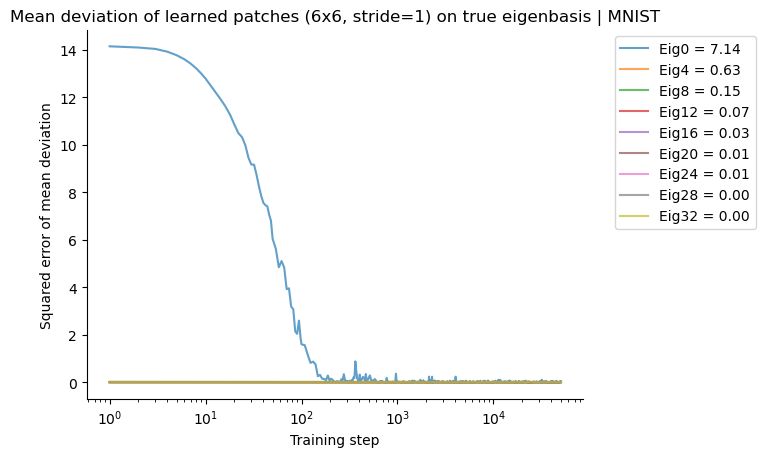

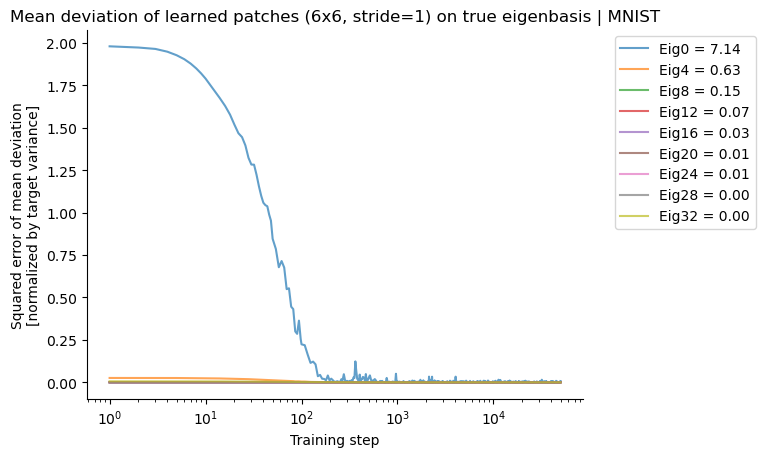

In [19]:
step_slice = sorted([*sample_store.keys()])
slice2plot = slice(None, None, 4)
plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval.cpu(), 
                           slice2plot, patch_size=patch_size, patch_stride=patch_stride, savedir=figdir, dataset_name="MNIST")
plot_mean_deviation_trajectories(step_slice, mean_x_patch_sample_traj, patch_mean.cpu(), patch_eigvec.cpu(), patch_eigval.cpu(), 
                           slice2plot, patch_size=patch_size, patch_stride=patch_stride, savedir=figdir, dataset_name="MNIST")

In [ ]:
figdir

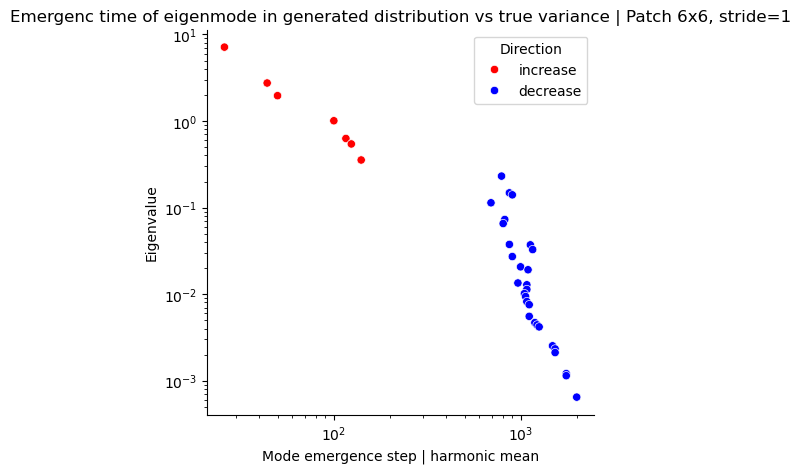

In [22]:
df = compute_crossing_points(patch_eigval, diag_cov_x_patch_sample_true_eigenbasis_traj, step_slice, smooth_sigma=3)
df.to_csv(f"{figdir}/synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)
plt.figure(figsize=[5, 5])
sns.scatterplot(data=df, x="emergence_step", y="Variance", hue="Direction", palette={"decrease": "blue", "increase": "red"})
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mode emergence step | harmonic mean")
plt.ylabel("Eigenvalue")
plt.title(f"Emergenc time of eigenmode in generated distribution vs true variance | Patch {patch_size}x{patch_size}, stride={patch_stride}")
saveallforms(figdir, f"synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance")
plt.show()

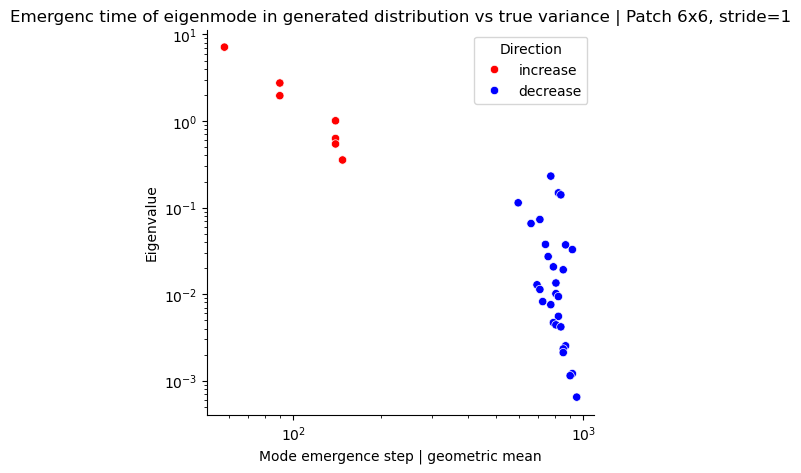

In [25]:
df = compute_crossing_points(patch_eigval.cpu(), diag_cov_x_patch_sample_true_eigenbasis_traj.cpu(), step_slice, smooth_sigma=3, threshold_type="geometric_mean")
df.to_csv(f"{figdir}/synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_geometric_mean_vs_variance.csv", index=False)
plt.figure(figsize=[5, 5])
sns.scatterplot(data=df, x="emergence_step", y="Variance", hue="Direction", palette={"decrease": "blue", "increase": "red"})
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mode emergence step | geometric mean")
plt.ylabel("Eigenvalue")
plt.title(f"Emergenc time of eigenmode in generated distribution vs true variance | Patch {patch_size}x{patch_size}, stride={patch_stride}")
saveallforms(figdir, f"synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_geometric_mean_vs_variance")
plt.show()

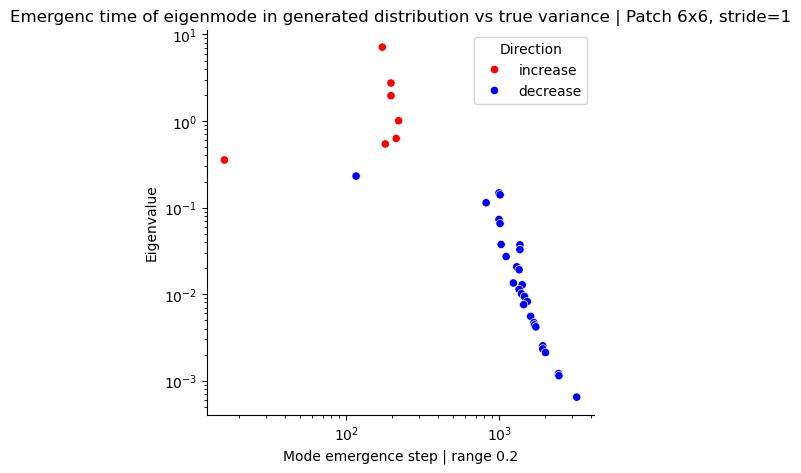

In [30]:
df = compute_crossing_points(patch_eigval.cpu(), diag_cov_x_patch_sample_true_eigenbasis_traj.cpu(), step_slice, smooth_sigma=3, threshold_type="range", threshold_fraction=0.2)
df.to_csv(f"{figdir}/synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_range02_vs_variance.csv", index=False)
plt.figure(figsize=[5, 5])
sns.scatterplot(data=df, x="emergence_step", y="Variance", hue="Direction", palette={"decrease": "blue", "increase": "red"})
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mode emergence step | range 0.2")
plt.ylabel("Eigenvalue")
plt.title(f"Emergenc time of eigenmode in generated distribution vs true variance | Patch {patch_size}x{patch_size}, stride={patch_stride}")
saveallforms(figdir, f"synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_range02_vs_variance")
plt.show()

## Older version

In [40]:
patch_size, patch_stride = 3, 1
images = Xtsr.view(Xtsr.shape[0], 1, 32, 32)
patches = extract_patches(images, patch_size=patch_size, patch_stride=patch_stride)
patch_shape = patches.shape[1:]
patch_dim = np.prod(patch_shape)

patch_cov = torch.cov(patches.view(patches.shape[0], -1).T)
patch_eigval, patch_eigvec = torch.linalg.eigh(patch_cov)
patch_eigval = patch_eigval.flip(0)
patch_eigvec = patch_eigvec.flip(1)

imgshape = (1, 32, 32)
true_cov_eigs = diag_var.cpu()
mean_x_patch_sample_traj = []
cov_x_patch_sample_traj = []
diag_cov_x_patch_sample_true_eigenbasis_traj = []
step_slice = [*sample_store.keys()]
for training_step in tqdm(step_slice):
    x_final, = sample_store[training_step]
    x_final_patches = extract_patches(x_final.view(x_final.shape[0], *imgshape), patch_size=patch_size, patch_stride=patch_stride)
    x_final_patches = x_final_patches.view(x_final_patches.shape[0], -1)
    mean_x_patch_sample = x_final_patches.mean(dim=0)
    cov_x_patch_sample = torch.cov(x_final_patches.T)
    mean_x_patch_sample_traj.append(mean_x_patch_sample.cpu())
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_patch_sample_true_eigenbasis = patch_eigvec.T @ cov_x_patch_sample @ patch_eigvec
    diag_cov_x_patch_sample_true_eigenbasis = torch.diag(cov_x_patch_sample_true_eigenbasis)
    diag_cov_x_patch_sample_true_eigenbasis_traj.append(diag_cov_x_patch_sample_true_eigenbasis.cpu())
    cov_x_patch_sample_traj.append(cov_x_patch_sample.cpu())
    
mean_x_patch_sample_traj = torch.stack(mean_x_patch_sample_traj).cpu()
cov_x_patch_sample_traj = torch.stack(cov_x_patch_sample_traj).cpu()
diag_cov_x_patch_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_patch_sample_true_eigenbasis_traj).cpu()

  0%|          | 0/124 [00:00<?, ?it/s]

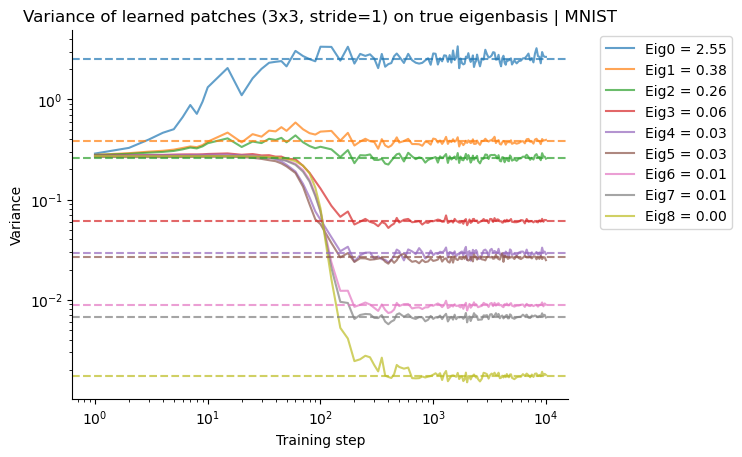

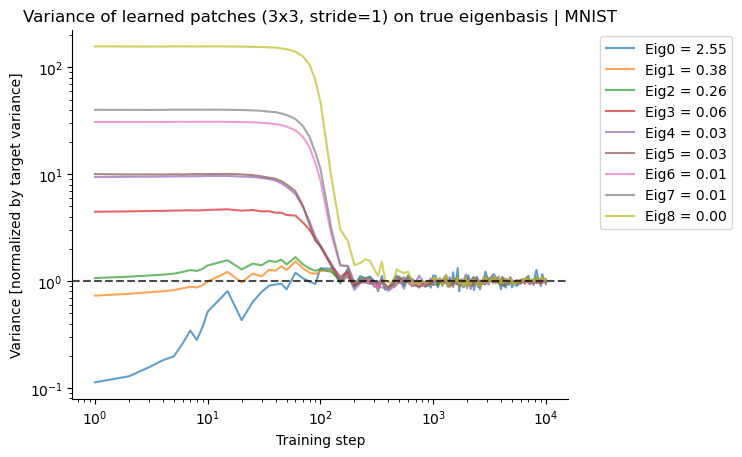

In [41]:
plt.figure()
slice2plot = slice(None, 9, 1)
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw")
plt.show()

plt.figure()
slice2plot = slice(None, 9, 1)
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized")
plt.show()

### Smallest patch 3x3

In [35]:
patch_size, patch_stride = 3, 3
images = Xtsr.view(Xtsr.shape[0], 1, 32, 32)
patches = extract_patches(images, patch_size=patch_size, patch_stride=patch_stride)
patch_shape = patches.shape[1:]
patch_dim = np.prod(patch_shape)

patch_cov = torch.cov(patches.view(patches.shape[0], -1).T)
patch_eigval, patch_eigvec = torch.linalg.eigh(patch_cov)
patch_eigval = patch_eigval.flip(0)
patch_eigvec = patch_eigvec.flip(1)

imgshape = (1, 32, 32)
true_cov_eigs = diag_var.cpu()
mean_x_patch_sample_traj = []
cov_x_patch_sample_traj = []
diag_cov_x_patch_sample_true_eigenbasis_traj = []
step_slice = [*sample_store.keys()]
for training_step in tqdm(step_slice):
    x_final, = sample_store[training_step]
    x_final_patches = extract_patches(x_final.view(x_final.shape[0], *imgshape), patch_size=patch_size, patch_stride=patch_stride)
    x_final_patches = x_final_patches.view(x_final_patches.shape[0], -1)
    mean_x_patch_sample = x_final_patches.mean(dim=0)
    cov_x_patch_sample = torch.cov(x_final_patches.T)
    mean_x_patch_sample_traj.append(mean_x_patch_sample.cpu())
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_patch_sample_true_eigenbasis = patch_eigvec.T @ cov_x_patch_sample @ patch_eigvec
    diag_cov_x_patch_sample_true_eigenbasis = torch.diag(cov_x_patch_sample_true_eigenbasis)
    diag_cov_x_patch_sample_true_eigenbasis_traj.append(diag_cov_x_patch_sample_true_eigenbasis.cpu())
    cov_x_patch_sample_traj.append(cov_x_patch_sample.cpu())
    
mean_x_patch_sample_traj = torch.stack(mean_x_patch_sample_traj).cpu()
cov_x_patch_sample_traj = torch.stack(cov_x_patch_sample_traj).cpu()
diag_cov_x_patch_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_patch_sample_true_eigenbasis_traj).cpu()

  0%|          | 0/124 [00:00<?, ?it/s]

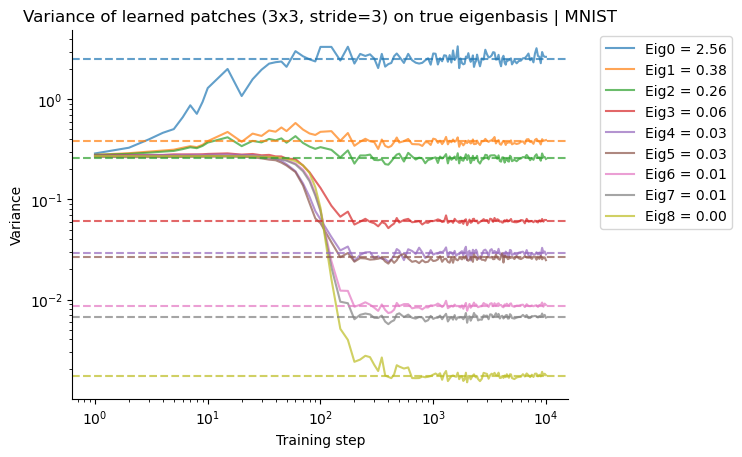

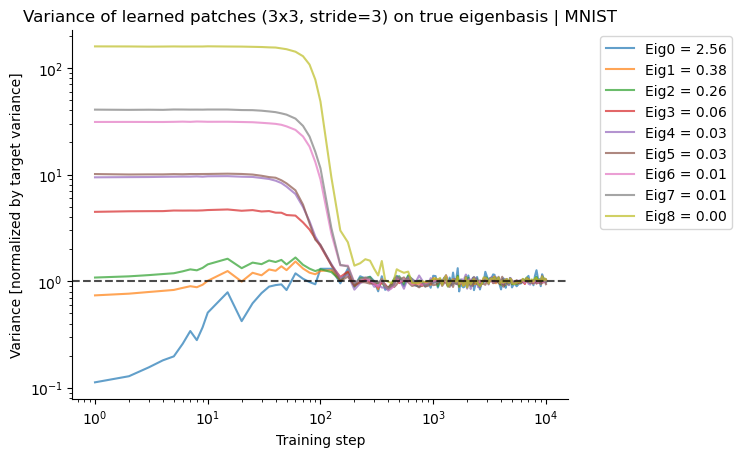

In [36]:
plt.figure()
slice2plot = slice(None, 9, 1)
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw")
plt.show()

plt.figure()
slice2plot = slice(None, 9, 1)
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized")
plt.show()

### Larger patches 6x6

In [31]:
patch_size, patch_stride = 6, 3
images = Xtsr.view(Xtsr.shape[0], 1, 32, 32)
patches = extract_patches(images, patch_size=patch_size, patch_stride=patch_stride)
patch_shape = patches.shape[1:]
patch_dim = np.prod(patch_shape)

patch_cov = torch.cov(patches.view(patches.shape[0], -1).T)
patch_eigval, patch_eigvec = torch.linalg.eigh(patch_cov)
patch_eigval = patch_eigval.flip(0)
patch_eigvec = patch_eigvec.flip(1)
imgshape = (1, 32, 32)
true_cov_eigs = diag_var.cpu()
mean_x_patch_sample_traj = []
cov_x_patch_sample_traj = []
diag_cov_x_patch_sample_true_eigenbasis_traj = []
step_slice = [*sample_store.keys()]
for training_step in tqdm(step_slice):
    x_final, = sample_store[training_step]
    x_final_patches = extract_patches(x_final.view(x_final.shape[0], *imgshape), patch_size=patch_size, patch_stride=patch_stride)
    x_final_patches = x_final_patches.view(x_final_patches.shape[0], -1)
    mean_x_patch_sample = x_final_patches.mean(dim=0)
    cov_x_patch_sample = torch.cov(x_final_patches.T)
    mean_x_patch_sample_traj.append(mean_x_patch_sample.cpu())
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_patch_sample_true_eigenbasis = patch_eigvec.T @ cov_x_patch_sample @ patch_eigvec
    diag_cov_x_patch_sample_true_eigenbasis = torch.diag(cov_x_patch_sample_true_eigenbasis)
    diag_cov_x_patch_sample_true_eigenbasis_traj.append(diag_cov_x_patch_sample_true_eigenbasis.cpu())
    cov_x_patch_sample_traj.append(cov_x_patch_sample.cpu())
    
mean_x_patch_sample_traj = torch.stack(mean_x_patch_sample_traj).cpu()
cov_x_patch_sample_traj = torch.stack(cov_x_patch_sample_traj).cpu()
diag_cov_x_patch_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_patch_sample_true_eigenbasis_traj).cpu()

  0%|          | 0/124 [00:00<?, ?it/s]

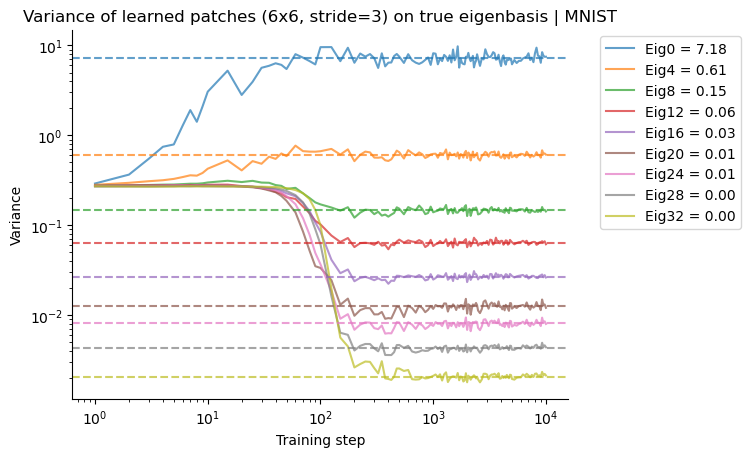

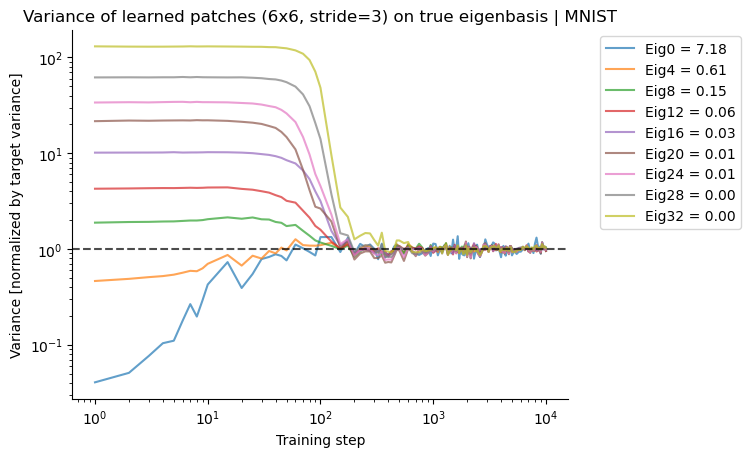

In [33]:

slice2plot = slice(None, 36, 4)
plt.figure()
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw")
plt.show()

plt.figure()
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized")
plt.show()

### Larger patches 9x9

In [37]:
patch_size, patch_stride = 9, 3
images = Xtsr.view(Xtsr.shape[0], 1, 32, 32)
patches = extract_patches(images, patch_size=patch_size, patch_stride=patch_stride)
patch_shape = patches.shape[1:]
patch_dim = np.prod(patch_shape)

patch_cov = torch.cov(patches.view(patches.shape[0], -1).T)
patch_eigval, patch_eigvec = torch.linalg.eigh(patch_cov)
patch_eigval = patch_eigval.flip(0)
patch_eigvec = patch_eigvec.flip(1)
imgshape = (1, 32, 32)
true_cov_eigs = diag_var.cpu()
mean_x_patch_sample_traj = []
cov_x_patch_sample_traj = []
diag_cov_x_patch_sample_true_eigenbasis_traj = []
step_slice = [*sample_store.keys()]
for training_step in tqdm(step_slice):
    x_final, = sample_store[training_step]
    x_final_patches = extract_patches(x_final.view(x_final.shape[0], *imgshape), patch_size=patch_size, patch_stride=patch_stride)
    x_final_patches = x_final_patches.view(x_final_patches.shape[0], -1)
    mean_x_patch_sample = x_final_patches.mean(dim=0)
    cov_x_patch_sample = torch.cov(x_final_patches.T)
    mean_x_patch_sample_traj.append(mean_x_patch_sample.cpu())
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_patch_sample_true_eigenbasis = patch_eigvec.T @ cov_x_patch_sample @ patch_eigvec
    diag_cov_x_patch_sample_true_eigenbasis = torch.diag(cov_x_patch_sample_true_eigenbasis)
    diag_cov_x_patch_sample_true_eigenbasis_traj.append(diag_cov_x_patch_sample_true_eigenbasis.cpu())
    cov_x_patch_sample_traj.append(cov_x_patch_sample.cpu())
    
mean_x_patch_sample_traj = torch.stack(mean_x_patch_sample_traj).cpu()
cov_x_patch_sample_traj = torch.stack(cov_x_patch_sample_traj).cpu()
diag_cov_x_patch_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_patch_sample_true_eigenbasis_traj).cpu()

  0%|          | 0/124 [00:00<?, ?it/s]

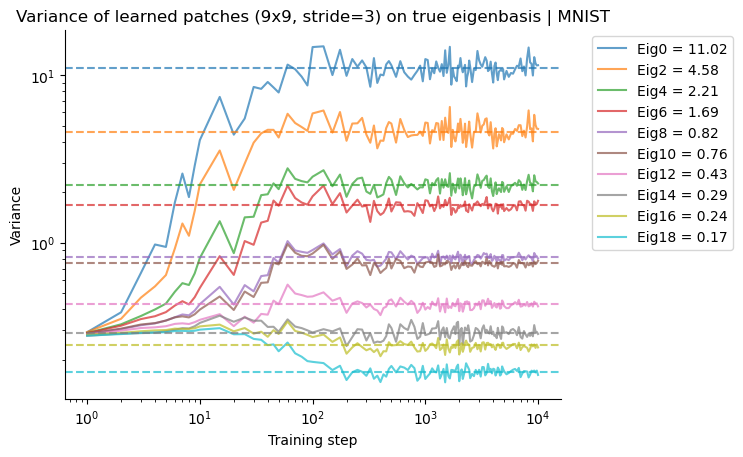

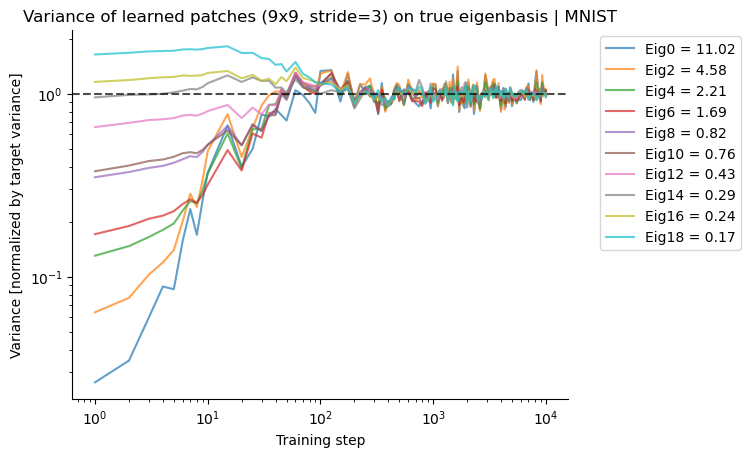

In [39]:
slice2plot = slice(None, 20, 2)
plt.figure()
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw_top20")
plt.show()

plt.figure()
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized_top20")
plt.show()

In [46]:
savedir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_4blocks_noattn'

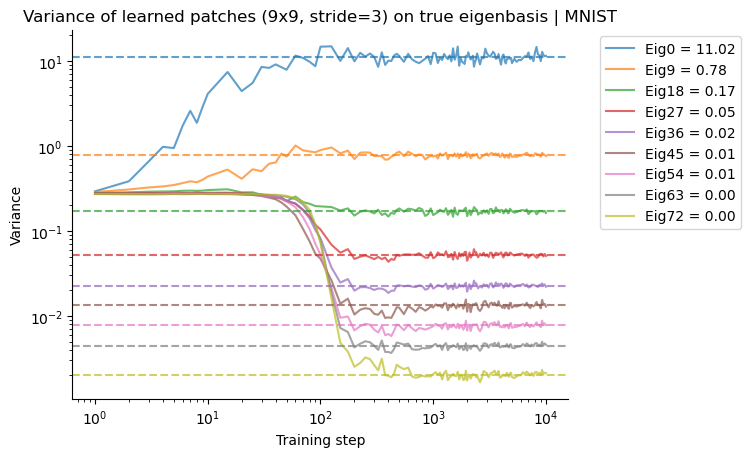

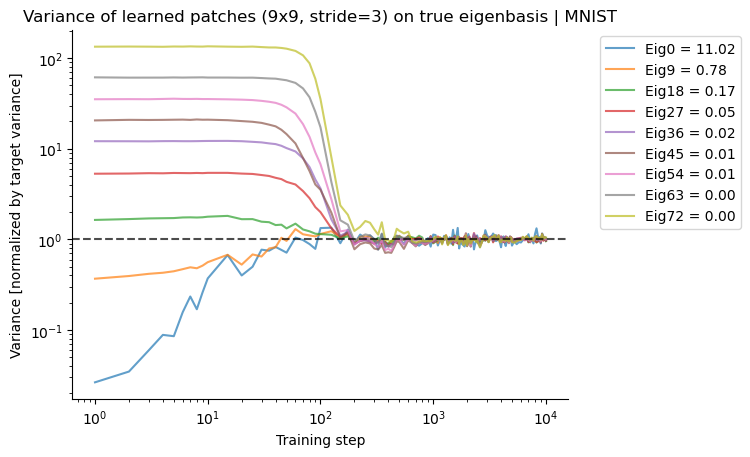

In [38]:
slice2plot = slice(None, 81, 9)
plt.figure()
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw")
plt.show()

plt.figure()
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized")
plt.show()

### Larger patches 16x16

In [42]:
patch_size, patch_stride = 16, 4
images = Xtsr.view(Xtsr.shape[0], 1, 32, 32)
patches = extract_patches(images, patch_size=patch_size, patch_stride=patch_stride)
patch_shape = patches.shape[1:]
patch_dim = np.prod(patch_shape)

patch_cov = torch.cov(patches.view(patches.shape[0], -1).T)
patch_eigval, patch_eigvec = torch.linalg.eigh(patch_cov)
patch_eigval = patch_eigval.flip(0)
patch_eigvec = patch_eigvec.flip(1)
imgshape = (1, 32, 32)
true_cov_eigs = diag_var.cpu()
mean_x_patch_sample_traj = []
cov_x_patch_sample_traj = []
diag_cov_x_patch_sample_true_eigenbasis_traj = []
step_slice = [*sample_store.keys()]
for training_step in tqdm(step_slice):
    x_final, = sample_store[training_step]
    x_final_patches = extract_patches(x_final.view(x_final.shape[0], *imgshape), patch_size=patch_size, patch_stride=patch_stride)
    x_final_patches = x_final_patches.view(x_final_patches.shape[0], -1)
    mean_x_patch_sample = x_final_patches.mean(dim=0)
    cov_x_patch_sample = torch.cov(x_final_patches.T)
    mean_x_patch_sample_traj.append(mean_x_patch_sample.cpu())
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_patch_sample_true_eigenbasis = patch_eigvec.T @ cov_x_patch_sample @ patch_eigvec
    diag_cov_x_patch_sample_true_eigenbasis = torch.diag(cov_x_patch_sample_true_eigenbasis)
    diag_cov_x_patch_sample_true_eigenbasis_traj.append(diag_cov_x_patch_sample_true_eigenbasis.cpu())
    cov_x_patch_sample_traj.append(cov_x_patch_sample.cpu())
    
mean_x_patch_sample_traj = torch.stack(mean_x_patch_sample_traj).cpu()
cov_x_patch_sample_traj = torch.stack(cov_x_patch_sample_traj).cpu()
diag_cov_x_patch_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_patch_sample_true_eigenbasis_traj).cpu()

  0%|          | 0/124 [00:00<?, ?it/s]

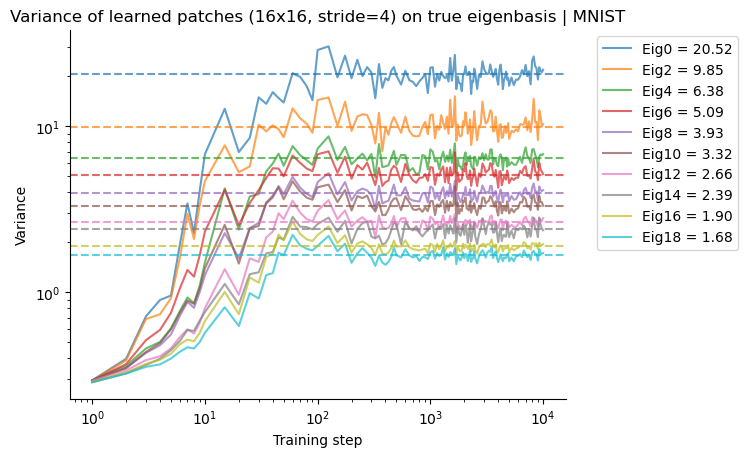

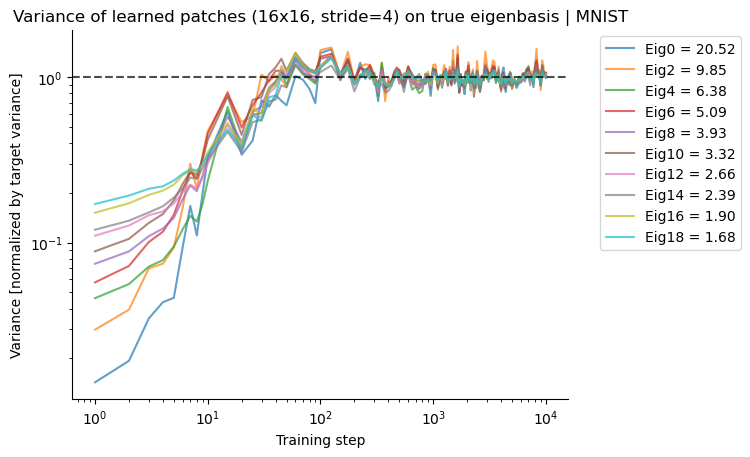

In [43]:
slice2plot = slice(None, 20, 2)
plt.figure()
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw_top20")
plt.show()

plt.figure()
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized_top20")
plt.show()

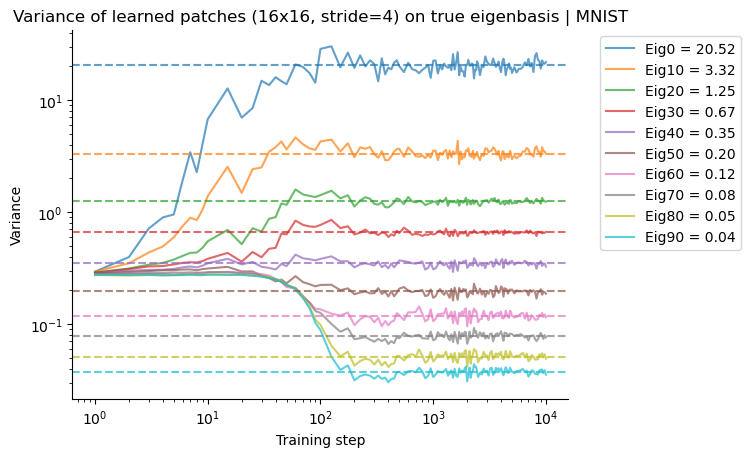

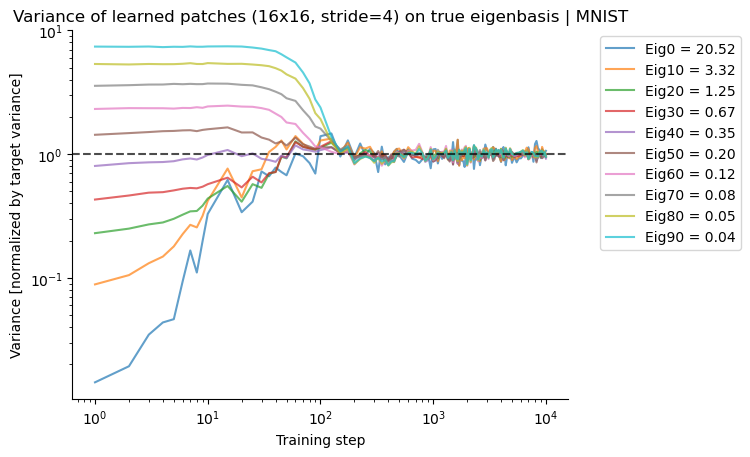

In [44]:
slice2plot = slice(None, 100, 10)
plt.figure()
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw")
plt.show()

plt.figure()
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized")
plt.show()

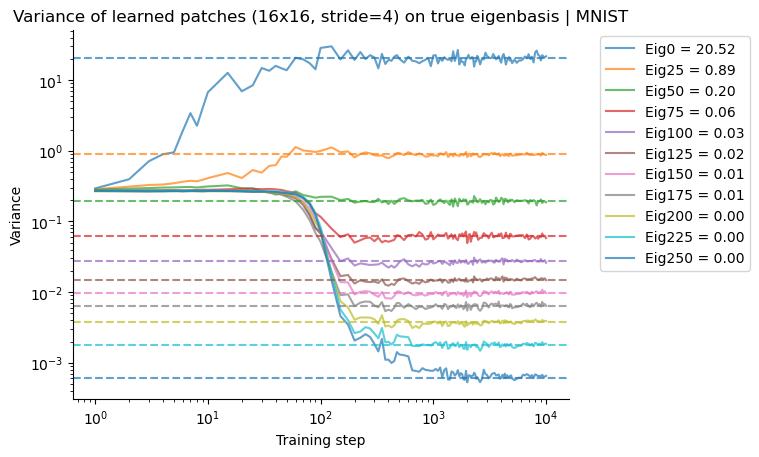

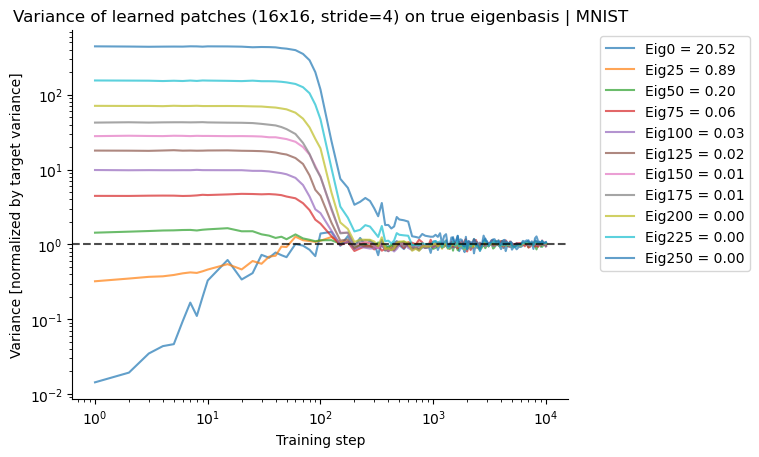

In [45]:
slice2plot = slice(None, 256, 25)
plt.figure()
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw")
plt.show()

plt.figure()
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized")
plt.show()